# Spatial Analysis Notebook: One polygon

The purpose of this code is to create a set of graphs based on one shapefile and one polygon.  This code was used to conduct preliminary analysis of case studies, but does not produce any specific figures in the paper.  It is provided in case others would like to conduct a drought analysis on a specific area.

To run this code, you need the following files in the appropriate folders:
 - Data/Output/Local
   - Master_ADWR_database_noduplicates.shp
   - Master_ADWR_database_water.shp
   - Wells55_GWSI_WLTS_DB_annual_updated.csv
 - Data/Input/Shapefiles
   - Any shapefiles of your choosing

In [1]:
# Packages and paths
# %%
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import geopandas as gp
import scipy.stats as sp
import sys

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/Local/'


Providing colors

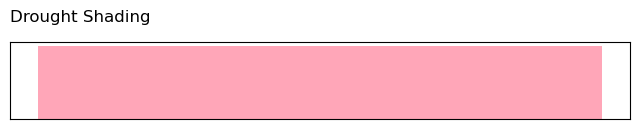

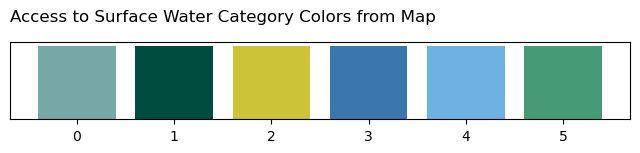

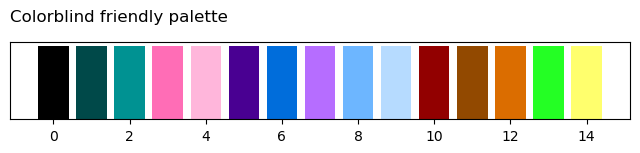

In [2]:
# %% Creating colors
drought_color = '#ffa6b8'

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Colors from map
cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map in the trend paper
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'
a2sw_colors =[cap,cap_secondary,noCAP,GWdom,mixed,swdom]

# Create a bar plot to visualize colors
palette = [drought_color]
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Drought Shading',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
ax.set_xticks([])
plt.show()

palette = a2sw_colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Access to Surface Water Category Colors from Map',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

palette = cblind
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Colorblind friendly palette',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

Read in the main databases.  You only have to do this once.

Master Database might take a while (~5-7 minutes).

In [3]:
# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)
print(filepath)

masterdb = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb.info())

../../Data/Output/Local/Master_ADWR_database_noduplicates.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 255849 entries, 0 to 255848
Data columns (total 80 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Combo_ID    255849 non-null  object        
 1   OBJECTID_g  45684 non-null   float64       
 2   SITE_ID     45684 non-null   object        
 3   LOCAL_ID    45684 non-null   object        
 4   REGISTRY_I  234704 non-null  object        
 5   WELL_TYPE   45684 non-null   object        
 6   DD_LAT      45684 non-null   float64       
 7   DD_LONG     45684 non-null   float64       
 8   LAT_NAD27   45684 non-null   object        
 9   LONG_NAD27  45684 non-null   object        
 10  WELL_ALT    45684 non-null   float64       
 11  WATER_USE_  45626 non-null   object        
 12  WELL_DEPTH  215436 non-null  float64       
 13  CASE_DIAM   33813 non-null   float64       
 14  WL_COUNT    45684 non-null   f

This one takes about 3-4 minutes to run

In [6]:
# Read in the database of number water wells
filename_mdb_w = 'Master_ADWR_database_water.shp'
filepath = os.path.join(outputpath, filename_mdb_w)
print(filepath)

masterdb_water = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb_water.info())

../../Data/Output/Local\Master_ADWR_database_water.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 142717 entries, 0 to 142716
Data columns (total 80 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    142717 non-null  object  
 1   OBJECTID_g  45631 non-null   float64 
 2   SITE_ID     45631 non-null   object  
 3   LOCAL_ID    45631 non-null   object  
 4   REGISTRY_I  121581 non-null  object  
 5   WELL_TYPE   45631 non-null   object  
 6   DD_LAT      45631 non-null   float64 
 7   DD_LONG     45631 non-null   float64 
 8   LAT_NAD27   45631 non-null   object  
 9   LONG_NAD27  45631 non-null   object  
 10  WELL_ALT    45631 non-null   float64 
 11  WATER_USE_  45573 non-null   object  
 12  WELL_DEPTH  130667 non-null  float64 
 13  CASE_DIAM   33772 non-null   float64 
 14  WL_COUNT    45631 non-null   float64 
 15  WL_DTW      34716 non-null   float64 
 16  WL_ELEV     34716 non-null   float64 
 17  SOUR

In [4]:
# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py

filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated.csv'
filepath = os.path.join(outputpath, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

#Block to do some formatting
annual_db = annual_db[1:168102]
annual_db.index = annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2.head()

../../Data/Output/Local/Wells55_GWSI_WLTS_DB_annual_updated.csv


,Combo_ID,1853.0,1856.0,1857.0,1860.0,1864.0,1868.0,1870.0,1871.0,1872.0,...,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,nan
0,60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,495.30,NaN,489.85,NaN,487.85,485.10,483.50,483.90,NaN,NaN
1,82721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2,83226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.00
3,83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,83716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00


### From here down is where you can rerun the code to generate graphs

In [61]:
# Read in the shapefile

# filename_shapeile = 'georeg_reproject_fixed.shp'
# filename_shapeile = '/flowlines_order4plus.shp'
filename_shapeile = '/huc4flowlines_order3plus.shp'
# filepath = os.path.join(shapepath, filename_shapeile)
filepath = os.path.join(outputpath+filename_shapeile)
shapefile = gp.read_file(filepath)
# shapefile.plot(cmap='viridis')


Take a look at the columns and variables

In [62]:
shapefile

,permanent_,gnis_name,reachcode,streamorde,ID,huc4,huc_name,fcode,geometry
0,149136270,Dodson Wash,15020005000065,5,None,1502,Little Colorado,46003,"LINESTRING Z (-110.22189 34.34674 0, -110.2217..."
1,149136272,Dodson Wash,15020005000066,5,None,1502,Little Colorado,46003,"LINESTRING Z (-110.22271 34.33082 0, -110.2227..."
2,149136273,Dodson Wash,15020005000067,5,None,1502,Little Colorado,46003,"LINESTRING Z (-110.22282 34.32381 0, -110.2227..."
3,149136329,Dodson Wash,15020005000068,5,None,1502,Little Colorado,46003,"LINESTRING Z (-110.22374 34.32175 0, -110.2237..."
4,149133749,Dodson Wash,15020005000064,5,None,1502,Little Colorado,46003,"LINESTRING Z (-110.21985 34.36593 0, -110.2201..."
...,...,...,...,...,...,...,...,...,...
184989,79196323,None,14070003000485,5,None,1407,Upper Colorado-Dirty Devil,46003,"LINESTRING Z (-111.63217 38.30203 0, -111.6321..."
184990,79196161,None,14070003002105,5,None,1407,Upper Colorado-Dirty Devil,46003,"LINESTRING Z (-111.72004 38.30775 0, -111.7196..."
184991,78979158,Upper Valley Creek,14070005000135,5,None,1407,Upper Colorado-Dirty Devil,46003,"LINESTRING Z (-111.77497 37.72374 0, -111.7747..."
184992,78978248,Birch Creek,14070005000124,4,None,1407,Upper Colorado-Dirty Devil,46006,"LINESTRING Z (-111.75492 37.77001 0, -111.7548..."


In [63]:
shapefile.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [64]:
# Define some things about your file

StudyArea = "HUC4s"
# Naming_col = "Name"
Naming_col = "huc4"
water_designation = swdom 

Before I do anything, we need to buffer our stream network to capture wells.  This should take about a minute, mostly for plotting.

<Axes: >

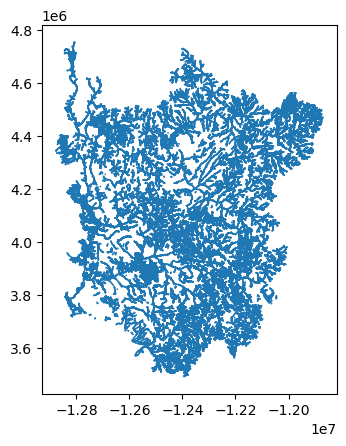

In [73]:
distance = 3000

buffered = shapefile.copy()  # Create a copy to avoid modifying the original
buffered = buffered.to_crs(3857)  # For whatever reason the crs needs to be 3857
# buffered = buffered.buffer(distance)  # Apply buffer
buffered["geometry"] = buffered.geometry.buffer(distance)
type(buffered)
buffered.plot()

In [74]:
buffered.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [75]:
# Export the buffered shapefile for creating maps
buffered.to_file(f'{outputpath}/bufferedflowlines_{distance}m.shp')

In [11]:
# If the above plot looks fine then turn shapefile variable into buffered
shapefile = buffered
shapefile

# Make sure the geometry column now says polygon

Merging the databases takes a little time - Approximately 3 minutes

In [16]:
# Merge the shapefile with the master database

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(epsg=26912)
# masterdb_water = masterdb_water.set_crs(epsg=26912)
# For main static database
static_geo = gp.sjoin(masterdb2, shapefile, how="inner"
                    #   , op='intersects'
                      , predicate='intersects'
                      )

print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")

# %% For the water wells water wells
# static_geo2 = gp.sjoin(masterdb_water, shapefile, how="inner", op='intersects')
# static_geo2.head()
# print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")


Master_ADWR_database_noduplicates.shp and /huc4flowlines_order3plus.shp join complete.


Check to make sure the merged dataframe looks good

In [17]:
static_geo

,Combo_ID,OBJECTID_g,SITE_ID,LOCAL_ID,REGISTRY_I,WELL_TYPE,DD_LAT,DD_LONG,LAT_NAD27,LONG_NAD27,...,geometry,index_right,permanent_,gnis_name,reachcode,streamorde,ID,huc4,huc_name,fcode
1,060001,18516563.00,334708112295301,B-05-02 08CCB,060001,INDEX,33.79,-112.50,33 47 6.2,112 29 52.1,...,POINT (361260.194 3739336.681),83895,141285310,None,15070102005157,4,None,1507,Lower Gila,46007
1,060001,18516563.00,334708112295301,B-05-02 08CCB,060001,INDEX,33.79,-112.50,33 47 6.2,112 29 52.1,...,POINT (361260.194 3739336.681),82276,141285141,None,15070102005123,4,None,1507,Lower Gila,46007
1,060001,18516563.00,334708112295301,B-05-02 08CCB,060001,INDEX,33.79,-112.50,33 47 6.2,112 29 52.1,...,POINT (361260.194 3739336.681),82270,141285142,None,15070102005124,4,None,1507,Lower Gila,46007
1,060001,18516563.00,334708112295301,B-05-02 08CCB,060001,INDEX,33.79,-112.50,33 47 6.2,112 29 52.1,...,POINT (361260.194 3739336.681),83885,141285121,None,15070102005103,4,None,1507,Lower Gila,46007
6,084067,NaN,None,None,084067,None,NaN,NaN,None,None,...,POINT (517507.2 3568961),30129,112919951,Tanque Verde Wash,15050302000096,6,None,1505,Middle Gila,46003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255842,931598,NaN,None,None,931598,None,NaN,NaN,None,None,...,POINT (264337.5 3842562),126549,143483389,Bitter Creek,15030201000258,4,None,1503,Lower Colorado,46003
255842,931598,NaN,None,None,931598,None,NaN,NaN,None,None,...,POINT (264337.5 3842562),122425,143483386,Bitter Creek,15030201000258,4,None,1503,Lower Colorado,46003
255846,931602,NaN,None,None,931602,None,NaN,NaN,None,None,...,POINT (505740 3466928),28006,fe57da88-ec24-4688-878a-9bdf74b4ef26,None,15050301022144,5,None,1505,Middle Gila,46003
255846,931602,NaN,None,None,931602,None,NaN,NaN,None,None,...,POINT (505740 3466928),28003,072f53e2-4b3a-4470-86fe-ff706ddee31d,None,15050301021794,5,None,1505,Middle Gila,46003


In [18]:
# Pull out the columns you need
# Use this for subbasins:
# reg_list = static_geo[['Combo_ID', Naming_col+'_right','WELL_DEPTH','WELL_TYPE_']]

# Use this or cities:
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_']]
# reg_list

# %% Converting Combo_ID to int
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_79757/3907601716.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')


In [19]:
reg_list.describe()

,Combo_ID,WELL_DEPTH
count,592722.00,507369.00
mean,34548299571184.51,200.43
std,101433795885116.80,280.08
min,60001.00,0.00
25%,526839.00,43.00
50%,602954.00,120.00
75%,702204.00,265.00
max,391085651560201.00,11555.00


<Axes: >

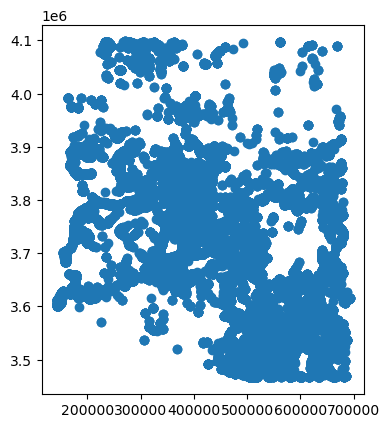

In [25]:
# shallow_wells = static_geo[static_geo['WELL_DEPTH']<200]


shallow_wells = static_geo[
    (static_geo['WELL_DEPTH'] < 200) & 
    (static_geo['huc4'].notna())
    ]

shallow_wells.plot()

<Axes: >

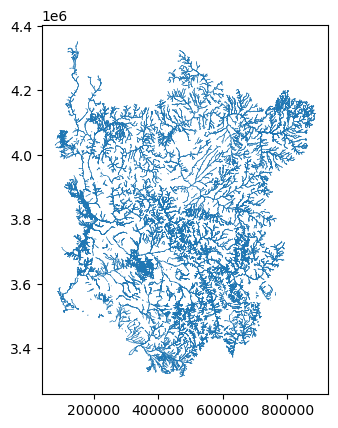

In [27]:
shapefile.plot()

In [22]:
depth_thresholds = [10, 50, 100, 150, 200, 250, 300]
wells_df = static_geo.copy()
summary_df = pd.DataFrame()
grouping_column = 'huc4'

for threshold in depth_thresholds:
    summary_df[f"Depth ≤ {threshold} ft"] = (
        wells_df[
            (wells_df["WELL_DEPTH"] <= threshold)
            #   & 
            # (wells_df["DTW_m"] < 10)
        ]
        .groupby(grouping_column)
        .size()
    )

summary_df.fillna(0, inplace=True)  # Replace NaN with 0 for HUCs with no wells meeting criteria
summary_df

,Depth ≤ 10 ft,Depth ≤ 50 ft,Depth ≤ 100 ft,Depth ≤ 150 ft,Depth ≤ 200 ft,Depth ≤ 250 ft,Depth ≤ 300 ft
huc4,,,,,,,
1407,25,37,73,73,93,105,105
1501,1387,2386,3555,4089,4524,4788,5213
1502,4129,10563,17538,22812,26105,28227,30334
1503,4605,13833,23634,28675,31621,33481,34474
1504,4505,10692,22467,27090,29894,31297,32917
1505,15563,26331,42861,55801,65568,72833,80196
1506,27459,67065,102013,128187,147453,160154,170462
1507,9161,13680,19560,25455,33841,40873,46415
1508,583,972,1291,1688,1985,2197,2372


In [29]:
# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('Combo_ID', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359315 entries, 0 to 359314
Columns: 165 entries, Combo_ID to WELL_TYPE_
dtypes: float64(162), int64(1), object(2)
memory usage: 452.3+ MB


In [33]:
combo

,1853.0,1856.0,1857.0,1860.0,1864.0,1868.0,1870.0,1871.0,1872.0,1873.0,...,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,nan,huc4,WELL_DEPTH,WELL_TYPE_
Combo_ID,,,,,,,,,,,,,,,,,,,,,
60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,487.85,485.10,483.50,483.90,NaN,NaN,1507,1000.00,NON-EXEMPT
60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,487.85,485.10,483.50,483.90,NaN,NaN,1507,1000.00,NON-EXEMPT
60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,487.85,485.10,483.50,483.90,NaN,NaN,1507,1000.00,NON-EXEMPT
60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,487.85,485.10,483.50,483.90,NaN,NaN,1507,1000.00,NON-EXEMPT
84067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,150.00,NON-EXEMPT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,33.30,NaN,NaN,NaN,NaN,1112.00,1505,155.00,NON-EXEMPT
627561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,33.30,NaN,NaN,NaN,NaN,1112.00,1505,155.00,NON-EXEMPT
627561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,33.30,NaN,NaN,NaN,NaN,1112.00,1505,155.00,NON-EXEMPT


In [ ]:
# Define the decades of interest
decades = list(range(1980, df_long["Year"].max() + 1, 10))

# Create an empty summary DataFrame
summary_df = pd.DataFrame()

# Loop through depth thresholds and count wells per HUC
for threshold in depth_thresholds:
    summary_df[f"Depth ≤ {threshold} ft"] = (
        df_long[
            (df_long["WELL_DEPTH"] <= threshold) & 
            (df_long["DTW_ft"] <= 32.8) &  # Filtering shallow groundwater (less than 10m)
            (df_long["Year"].isin(decades))  # Keep only the desired decades
        ]
        .groupby(["huc4", "Year"])["Combo_ID"]
        .nunique()  # Count unique well IDs per HUC per decade
    ).unstack()  # Spread years into columns for easier viewing

# Fill NaNs with 0 (some HUCs may not meet criteria)
summary_df.fillna(0, inplace=True)

# Display the summary table
summary_df = summary_df.iloc[1:, :]  # Keep this if you need to drop the first row
summary_df

In [50]:
wells_df = combo.copy()
wells_df = wells_df.reset_index()
wells_df = wells_df.drop(['WELL_TYPE_'],axis=1)

# Convert from wide format (years as columns) to long format (Year, DTW values)
df_long = wells_df.melt(id_vars=["Combo_ID", "huc4", "WELL_DEPTH"], 
                         var_name="Year", value_name="DTW_ft")

# Convert Year to integer if needed
df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")

# Define the decades of interest
# decades = list(range(1980, df_long["Year"].max() + 1, 10))

# Create an empty summary DataFrame
summary_df = pd.DataFrame()

# Loop through depth thresholds and count wells per HUC
for threshold in depth_thresholds:
    summary_df[f"Depth ≤ {threshold} ft"] = (
        df_long[
            (df_long["WELL_DEPTH"] <= threshold) & 
            (df_long["DTW_ft"] <= 32.8) & # Filtering shallow groundwater (less than 10m)
            (df_long['Year'] >= 1980)
        ]
        .groupby("huc4")["Combo_ID"]
        .nunique()  # Count unique well IDs per HUC
    )

# Fill NaNs with 0 (some HUCs may not meet criteria)
summary_df.fillna(0, inplace=True)

# Display the summary table
summary_df = summary_df.iloc[1:,:]
summary_df


,Depth ≤ 10 ft,Depth ≤ 50 ft,Depth ≤ 100 ft,Depth ≤ 150 ft,Depth ≤ 200 ft,Depth ≤ 250 ft,Depth ≤ 300 ft
huc4,,,,,,,
1501,43,98,167,189,209,218,223
1502,46,587,771,866,909,927,946
1503,38,651,1005,1111,1175,1209,1219
1504,41,260,641,761,814,842,863
1505,139,689,1128,1398,1550,1654,1720
1506,86,1082,1802,2231,2468,2614,2719
1507,60,402,676,889,1006,1076,1159
1508,32,59,75,78,87,93,95


In [55]:
wells_df = combo.copy()
wells_df = wells_df.reset_index()
wells_df = wells_df.drop(['WELL_TYPE_'],axis=1)

# Convert from wide format (years as columns) to long format (Year, DTW values)
df_long = wells_df.melt(id_vars=["Combo_ID", "huc4", "WELL_DEPTH"], 
                         var_name="Year", value_name="DTW_ft")

# Convert Year to integer if needed
df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")

# Define the decades of interest, ensuring they're integers
df_long["Year"] = df_long["Year"].astype("Int64")  # Converts Year column to integer (handles NaNs)
decades = list(range(1980, df_long["Year"].max() + 1, 10))  # Generate decade list

# Create an empty summary DataFrame
summary_df = pd.DataFrame()

# Loop through depth thresholds and count wells per HUC & decade
for threshold in depth_thresholds:
    summary_df[f"Depth ≤ {threshold} ft"] = (
        df_long[
            (df_long["WELL_DEPTH"] <= threshold) & 
            (df_long["DTW_ft"] <= 32.8) &  # Filtering shallow groundwater (less than 10m)
            (df_long["Year"] >= 1980)  # Keep only the desired decades
        ]
        .groupby(["huc4", "Year"])["Combo_ID"]
        .nunique()  # Count unique wells per HUC per decade
    )

# Fill NaNs with 0 (some HUCs may not meet criteria)
summary_df.fillna(0, inplace=True)

# Reset index so HUC and Year (Decade) remain as a MultiIndex
summary_df = summary_df.reset_index().set_index(["huc4", "Year"])

# Display the summary table
# summary_df = summary_df.iloc[1:, :]  # Keep this if you need to drop the first row
print(summary_df)


           Depth ≤ 10 ft  Depth ≤ 50 ft  Depth ≤ 100 ft  Depth ≤ 150 ft  \
huc4 Year                                                                 
1407 2007              1              1               1               1   
1501 1984             17             17              19              19   
     1985              2              2               3               3   
     1986              6              6               9              10   
     1987              3              5               8               8   
...                  ...            ...             ...             ...   
1508 1996              3              8               9               9   
     1997              2              2               2               2   
     2007              1              2               3               4   
     2019              3              9              10              11   
     2020              3             12              13              14   

           Depth ≤ 200 f

In [53]:
# Convert Year to integer, handling any NaN or incorrect formats (convert errors to NaN)
df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce").astype("Int64")

# Check the range of years and any missing values
print(f"Year Range: {df_long['Year'].min()} - {df_long['Year'].max()}")
print(f"Number of NaN years: {df_long['Year'].isna().sum()}")

# Define the decades of interest
decades = list(range(1980, df_long["Year"].max() + 1, 10))
print(f"Decades List: {decades}")

Year Range: 1853 - 2024
Number of NaN years: 359315
Decades List: [1980, 1990, 2000, 2010, 2020]


In [42]:
summary_df

,Depth ≤ 50 ft,Depth ≤ 100 ft,Depth ≤ 150 ft,Depth ≤ 200 ft,Depth ≤ 250 ft,Depth ≤ 300 ft
huc4,,,,,,
1407,3,5,5,5,5,5
1501,321,441,473,497,506,512
1502,1145,1419,1553,1625,1656,1687
1503,1272,1806,2012,2128,2188,2215
1504,980,1771,1963,2038,2074,2111
1505,2570,3279,3706,3951,4117,4260
1506,2848,3784,4318,4634,4839,4984
1507,1510,1921,2213,2379,2488,2596
1508,139,160,168,187,197,201


In [112]:
# Grouping the appropriate column
combo_copy = combo.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'],axis=1)
# cat_wl = combo_copy.groupby([Naming_col+"_right"]).mean()
cat_wl = combo_copy.groupby([Naming_col]).mean()

In [113]:
# Clean up the dataframe for graphing
cat_wl2 = cat_wl.copy()
i = cat_wl2
# del i['WELL_DEPTH']
f = i.transpose()
f.reset_index(inplace=True)
f['index'] = pd.to_numeric(f['index'])
f['index'] = f['index'].astype(int)
f.set_index('index', inplace=True)
f.info()
cat_wl2 = f
cat_wl2

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 1853 to 2024
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1407    4 non-null      float64
 1   1408    23 non-null     float64
 2   1501    99 non-null     float64
 3   1502    123 non-null    float64
 4   1503    111 non-null    float64
 5   1504    122 non-null    float64
 6   1505    136 non-null    float64
 7   1506    130 non-null    float64
 8   1507    122 non-null    float64
 9   1508    106 non-null    float64
dtypes: float64(10)
memory usage: 13.1 KB


huc4,1407,1408,1501,1502,1503,1504,1505,1506,1507,1508
index,,,,,,,,,,
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1856,NaN,NaN,NaN,NaN,40.00,NaN,NaN,NaN,NaN,NaN
1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.00,NaN
1860,NaN,NaN,NaN,18.00,NaN,NaN,NaN,NaN,NaN,NaN
1864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020,NaN,NaN,331.57,60.69,93.07,74.28,122.77,90.25,217.62,28.98
2021,NaN,NaN,328.00,77.55,88.12,143.36,95.73,76.84,220.23,149.46
2022,NaN,NaN,291.90,119.72,95.47,208.65,130.08,77.24,233.72,102.21


### Analysis and Graphing

In [114]:
Min_year_of_Study = 2000
Max_year_of_Study = 2024

# Water Analysis period
wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=Max_year_of_Study)]
wlanalysis_period.head(25)

huc4,1407,1408,1501,1502,1503,1504,1505,1506,1507,1508
index,,,,,,,,,,
2000,NaN,9.00,154.85,102.46,77.58,77.52,113.60,50.65,192.72,130.26
2001,NaN,17.44,242.19,101.22,60.35,58.82,96.70,84.88,186.98,129.67
2002,NaN,13.00,220.05,75.95,50.80,94.85,123.37,76.16,164.60,111.96
2003,NaN,72.06,271.72,95.91,72.69,59.42,154.62,81.17,188.30,65.55
2004,NaN,57.42,198.65,64.40,57.42,70.24,142.10,73.30,153.68,150.48
2005,NaN,NaN,296.87,131.24,66.65,78.89,127.66,90.58,194.31,81.89
2006,NaN,NaN,282.51,131.24,83.15,59.36,88.33,89.89,171.84,159.73
2007,5.00,NaN,208.56,96.79,53.57,110.23,148.53,81.40,186.65,86.14
2008,NaN,NaN,202.43,57.50,32.45,80.06,139.34,56.19,138.45,99.47


This is helpful if you're missing values and it won't calculate statistics

In [43]:
df_interpolated = wlanalysis_period.interpolate(method='linear', axis=0)
df_interpolated

huc4,1408,1501,1502,1503,1504,1505,1506,1507,1508
index,,,,,,,,,
2000,NaN,129.06,20.15,25.02,116.28,54.65,42.86,192.72,29.30
2001,13.00,205.62,151.75,67.33,22.27,62.97,54.02,141.60,280.00
2002,13.00,170.70,177.50,42.48,85.70,103.15,48.94,150.61,29.95
2003,15.39,209.62,43.70,84.88,19.10,190.06,43.28,181.18,30.44
2004,17.77,174.08,77.23,55.17,40.77,102.03,61.42,141.40,266.77
2005,17.77,383.42,44.43,30.27,86.82,96.37,42.55,306.80,66.17
2006,17.77,198.28,56.80,13.43,36.39,91.13,75.65,181.07,134.35
2007,17.77,220.45,93.40,19.77,121.76,119.99,59.01,181.93,62.22
2008,17.77,258.68,19.31,17.57,38.50,103.82,26.09,89.73,40.74


            1501  1502    1503     1504    1505    1506     1507  1505
slope       1.86   NaN   -0.56     2.40   -1.19   -0.70     2.57   NaN
int     -3531.50   NaN 1167.75 -4764.75 2481.81 1454.34 -4970.98   NaN
rsq         0.03   NaN    0.05     0.08    0.08    0.13     0.14   NaN
p_val       0.44   NaN    0.33     0.18    0.19    0.09     0.07   NaN
std_err     2.35   NaN    0.57     1.72    0.88    0.40     1.37   NaN
mean      212.81   NaN   34.73    70.27   92.97   43.78   191.15   NaN
var      5263.95   NaN  309.50  2994.98  782.62  167.58  2023.85   NaN
sum      4894.54   NaN  798.84  1616.13 2138.35 1006.84  4396.35   NaN


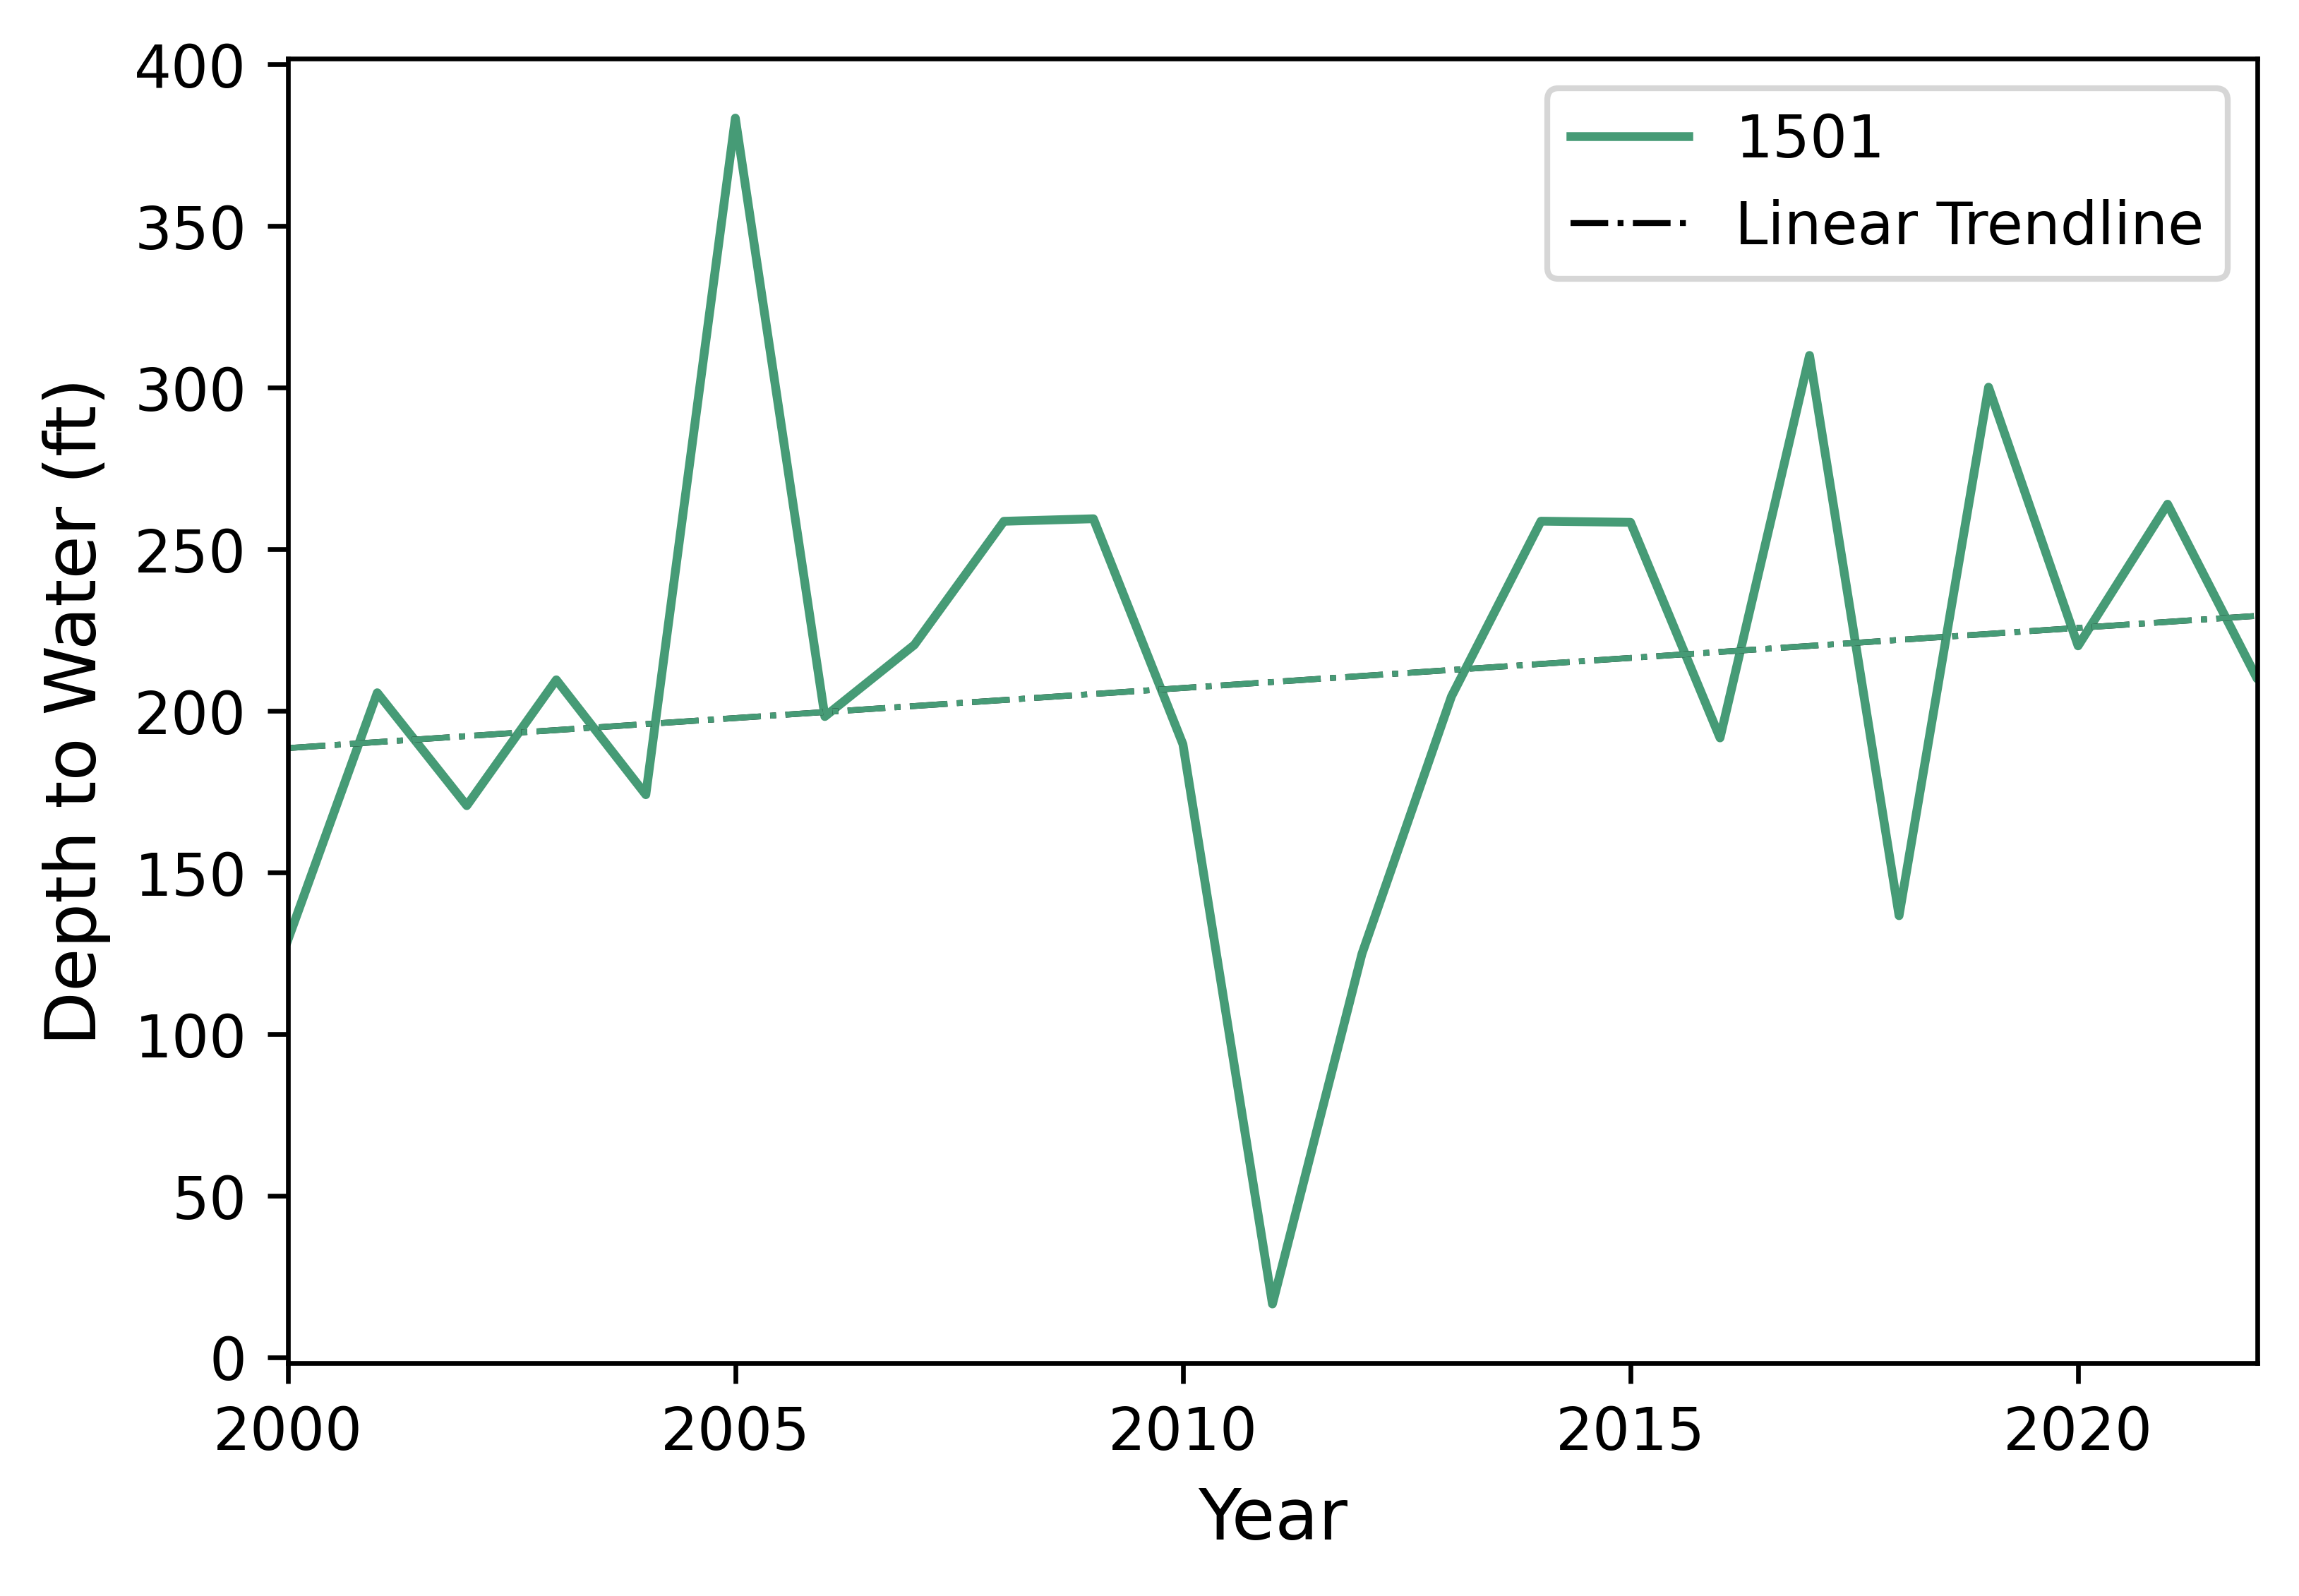

In [60]:
ds = wlanalysis_period[['1501','1502','1503','1504','1505','1506','1507','1508']]
min_yr = 2000
mx_yr = 2022
Name = "mean_"+StudyArea

betterlabels = ['1501','1502','1503','1504','1505','1506','1507','1505']

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
columns = ds.columns
column_list = ds.columns.tolist()

stats = pd.DataFrame()
# for i in range(1, 12, 1):
for i in column_list:
        df = f[i]
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope, 
                              'int':intercept, 
                              'rsq':r_value*r_value, 
                              'p_val':p_value, 
                              'std_err':std_err, 
                              'mean': np.mean(y),
                              'var': np.var(y),
                              'sum': np.sum(y)
                              },
                              ignore_index=True)


stats.index = betterlabels
stats1 = stats.transpose()
print(stats1)
# stats1.to_csv(outputpath_local+'Stats_'+StudyArea+'.csv')

# -- Data visualization --
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()
m1 = round(stats1.loc['slope',betterlabels[0]], 2)
yint1 = round(stats1.loc['int',betterlabels[0]], 2)
pval1 = round(stats1.loc['p_val',betterlabels[0]], 4)
yf1 = (m1*xf)+yint1

fig, ax = plt.subplots(1, 1, figsize = (6,4))

ylim = 100
fsize = 12

# Set x ticks to every 5 years
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

ax.plot(ds[column_list[0]], label=betterlabels[0], color=water_designation)

ax.plot(xf1, yf1,"-.",color='k',label='Linear Trendline', lw=1)
# ax.plot(xf1, yf1,"-.",color='k', lw=1)
ax.plot(xf1, yf1,"-.", color=water_designation, lw=1)

# Adding text inside the plot
# ax.text(min_yr+0.5, 2, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
# ax.text(min_yr+0.5, ylim-2, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

ax.set_xlim(min_yr,mx_yr)
# ax.set_ylim(ylim,0)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=0)
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

# plt.savefig(figurepath+Name, bbox_inches = 'tight')

            1501  1502    1503     1504    1505    1506     1507  1508
slope       1.86   NaN   -0.56     2.40   -1.19   -0.70     2.57   NaN
int     -3531.50   NaN 1167.75 -4764.75 2481.81 1454.34 -4970.98   NaN
rsq         0.03   NaN    0.05     0.08    0.08    0.13     0.14   NaN
p_val       0.44   NaN    0.33     0.18    0.19    0.09     0.07   NaN
std_err     2.35   NaN    0.57     1.72    0.88    0.40     1.37   NaN
mean      212.81   NaN   34.73    70.27   92.97   43.78   191.15   NaN
var      5263.95   NaN  309.50  2994.98  782.62  167.58  2023.85   NaN
sum      4894.54   NaN  798.84  1616.13 2138.35 1006.84  4396.35   NaN
Plots saved successfully!


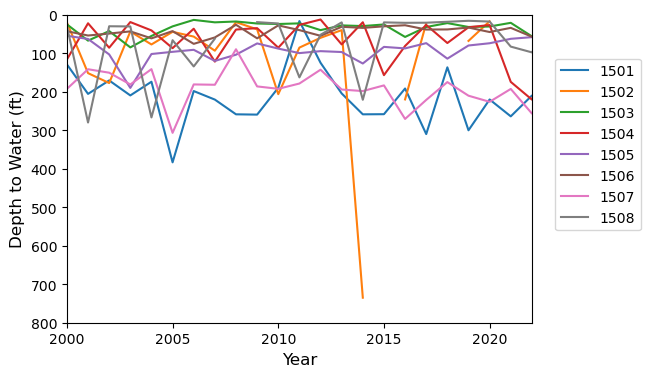

In [61]:
# Define dataset
ds = wlanalysis_period[['1501','1502','1503','1504','1505','1506','1507','1508']]
min_yr = 2000
mx_yr = 2022
Name = "mean_"+StudyArea

betterlabels = ['1501','1502','1503','1504','1505','1506','1507','1508']  # Fixed duplicate '1505'

ylim = 800

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
column_list = ds.columns.tolist()

stats = pd.DataFrame()

for col in column_list:
    df = f[col]
    y = np.array(df.values, dtype=float)
    x = np.array(df.index.values, dtype=float)  # Keeping as float for linregress

    # Calculate linear regression stats
    slope, intercept, r_value, p_value, std_err = sp.linregress(x, y)
    
    # Append statistics to dataframe
    stats = stats._append({
        'slope': slope, 
        'int': intercept, 
        'rsq': r_value * r_value, 
        'p_val': p_value, 
        'std_err': std_err, 
        'mean': np.mean(y),
        'var': np.var(y),
        'sum': np.sum(y)
    }, ignore_index=True)

stats.index = betterlabels
stats1 = stats.transpose()
print(stats1)

fig, ax = plt.subplots(figsize=(6, 4))

# ---- Plot Each Column ----
for i, col in enumerate(column_list):
    x_vals = np.linspace(min_yr, mx_yr, 100)
    m = round(stats1.loc['slope', betterlabels[i]], 2)
    y_int = round(stats1.loc['int', betterlabels[i]], 2)
    y_vals = (m * x_vals) + y_int

    ax.plot(ds[col], label=betterlabels[i]
            # , color='blue'
            )  # Adjust color as needed)
    
# ax.plot(x_vals, y_vals, "-.", color='k', label='Linear Trendline', lw=1)

# Formatting
ax.set_ylim(ylim,0)
ax.set_xticks(np.arange(min_yr, mx_yr + 1, 5))
ax.set_xlim(min_yr, mx_yr)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Depth to Water (ft)', fontsize=12)
ax.legend(loc=[1.05,0.3])


            1501    1502     1503     1504    1505    1506     1507    1508
slope       4.45   -0.31     1.85     2.87   -0.03    0.53     2.97   -1.75
int     -8707.75  716.60 -3649.61 -5672.32  196.38 -985.39 -5765.07 3617.45
rsq         0.21    0.01     0.19     0.26    0.00    0.08     0.53    0.10
p_val       0.03    0.70     0.04     0.01    0.95    0.19     0.00    0.15
std_err     1.87    0.80     0.84     1.06    0.57    0.39     0.62    1.16
mean      246.94   96.21    72.22    91.76  127.23   80.46   203.17   95.80
var      4100.14  588.25   801.29  1407.98  304.96  155.16   738.03 1382.31
sum      5679.60 2212.78  1660.95  2110.44 2926.19 1850.61  4672.92 2203.34


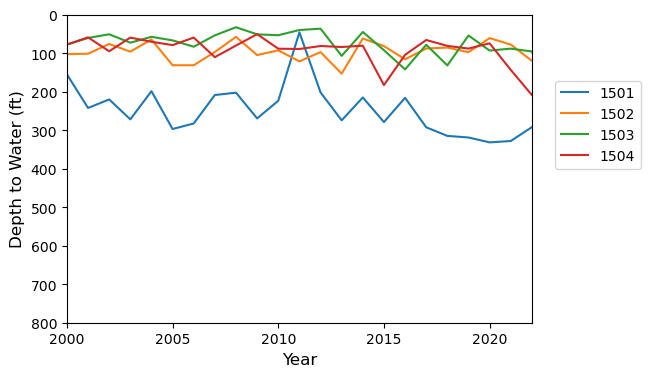

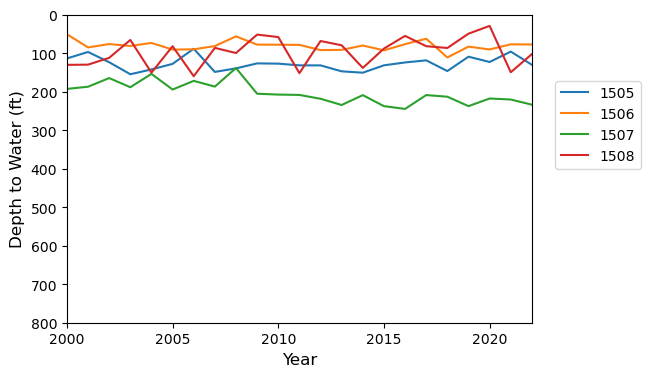

In [115]:
# Define dataset
ds = wlanalysis_period[['1501','1502','1503','1504','1505','1506','1507','1508']]
min_yr = 2000
mx_yr = 2022
Name = "mean_" + StudyArea

betterlabels = ['1501','1502','1503','1504','1505','1506','1507','1508']

ylim = 800

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
column_list = ds.columns.tolist()

stats = pd.DataFrame()

# Compute statistics
for col in column_list:
    df = f[col]
    y = np.array(df.values, dtype=float)
    x = np.array(df.index.values, dtype=float)  

    # Linear regression stats
    slope, intercept, r_value, p_value, std_err = sp.linregress(x, y)

    # Append statistics
    stats = stats._append({
        'slope': slope, 
        'int': intercept, 
        'rsq': r_value * r_value, 
        'p_val': p_value, 
        'std_err': std_err, 
        'mean': np.mean(y),
        'var': np.var(y),
        'sum': np.sum(y)
    }, ignore_index=True)

stats.index = betterlabels
stats1 = stats.transpose()
print(stats1)

# ---- Plot in Groups of 4 ----
batch_size = 4
for i in range(0, len(column_list), batch_size):
    fig, ax = plt.subplots(figsize=(6, 4))

    for col in column_list[i:i+batch_size]:  # Select four at a time
        ax.plot(ds[col], label=col)  
    
    # Formatting
    ax.set_ylim(ylim, 0)
    ax.set_xticks(np.arange(min_yr, mx_yr + 1, 5))
    ax.set_xlim(min_yr, mx_yr)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Depth to Water (ft)', fontsize=12)
    ax.legend(loc=[1.05,0.5])

    # Show each figure before saving
    plt.show()


In [21]:
# Anomaly's
# ds = wlanalysis_period.copy()
ds = df_interpolated.copy()
columns = ds.columns
column_list = ds.columns.tolist()
# trend_df = wlanalysis_period.copy()
trend_df = df_interpolated.copy()
dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        # trend_df[i] = (wlanalysis_period.index*slope) + intercept
        # dtw_anomalys[i] = wlanalysis_period[i] - trend_df[i]
        trend_df[i] = (df_interpolated.index*slope) + intercept
        dtw_anomalys[i] = df_interpolated[i] - trend_df[i]
        

dtw_anomalys.head()

,YUMA
index,
2000,3.28
2001,22.18
2002,-5.85
2003,-5.11
2004,-4.68


Results for Yuma (2000-2022):
Kendall Correlation coefficient
 YUMA:
  tau = -0.004
  pval = 1.0
Spearman Correlation coefficient
 YUMA:
  rho = -0.017
  pval = 0.9394
Pearson Correlation coefficient
 YUMA:
  rsq = 0.023
  pval = 0.4861



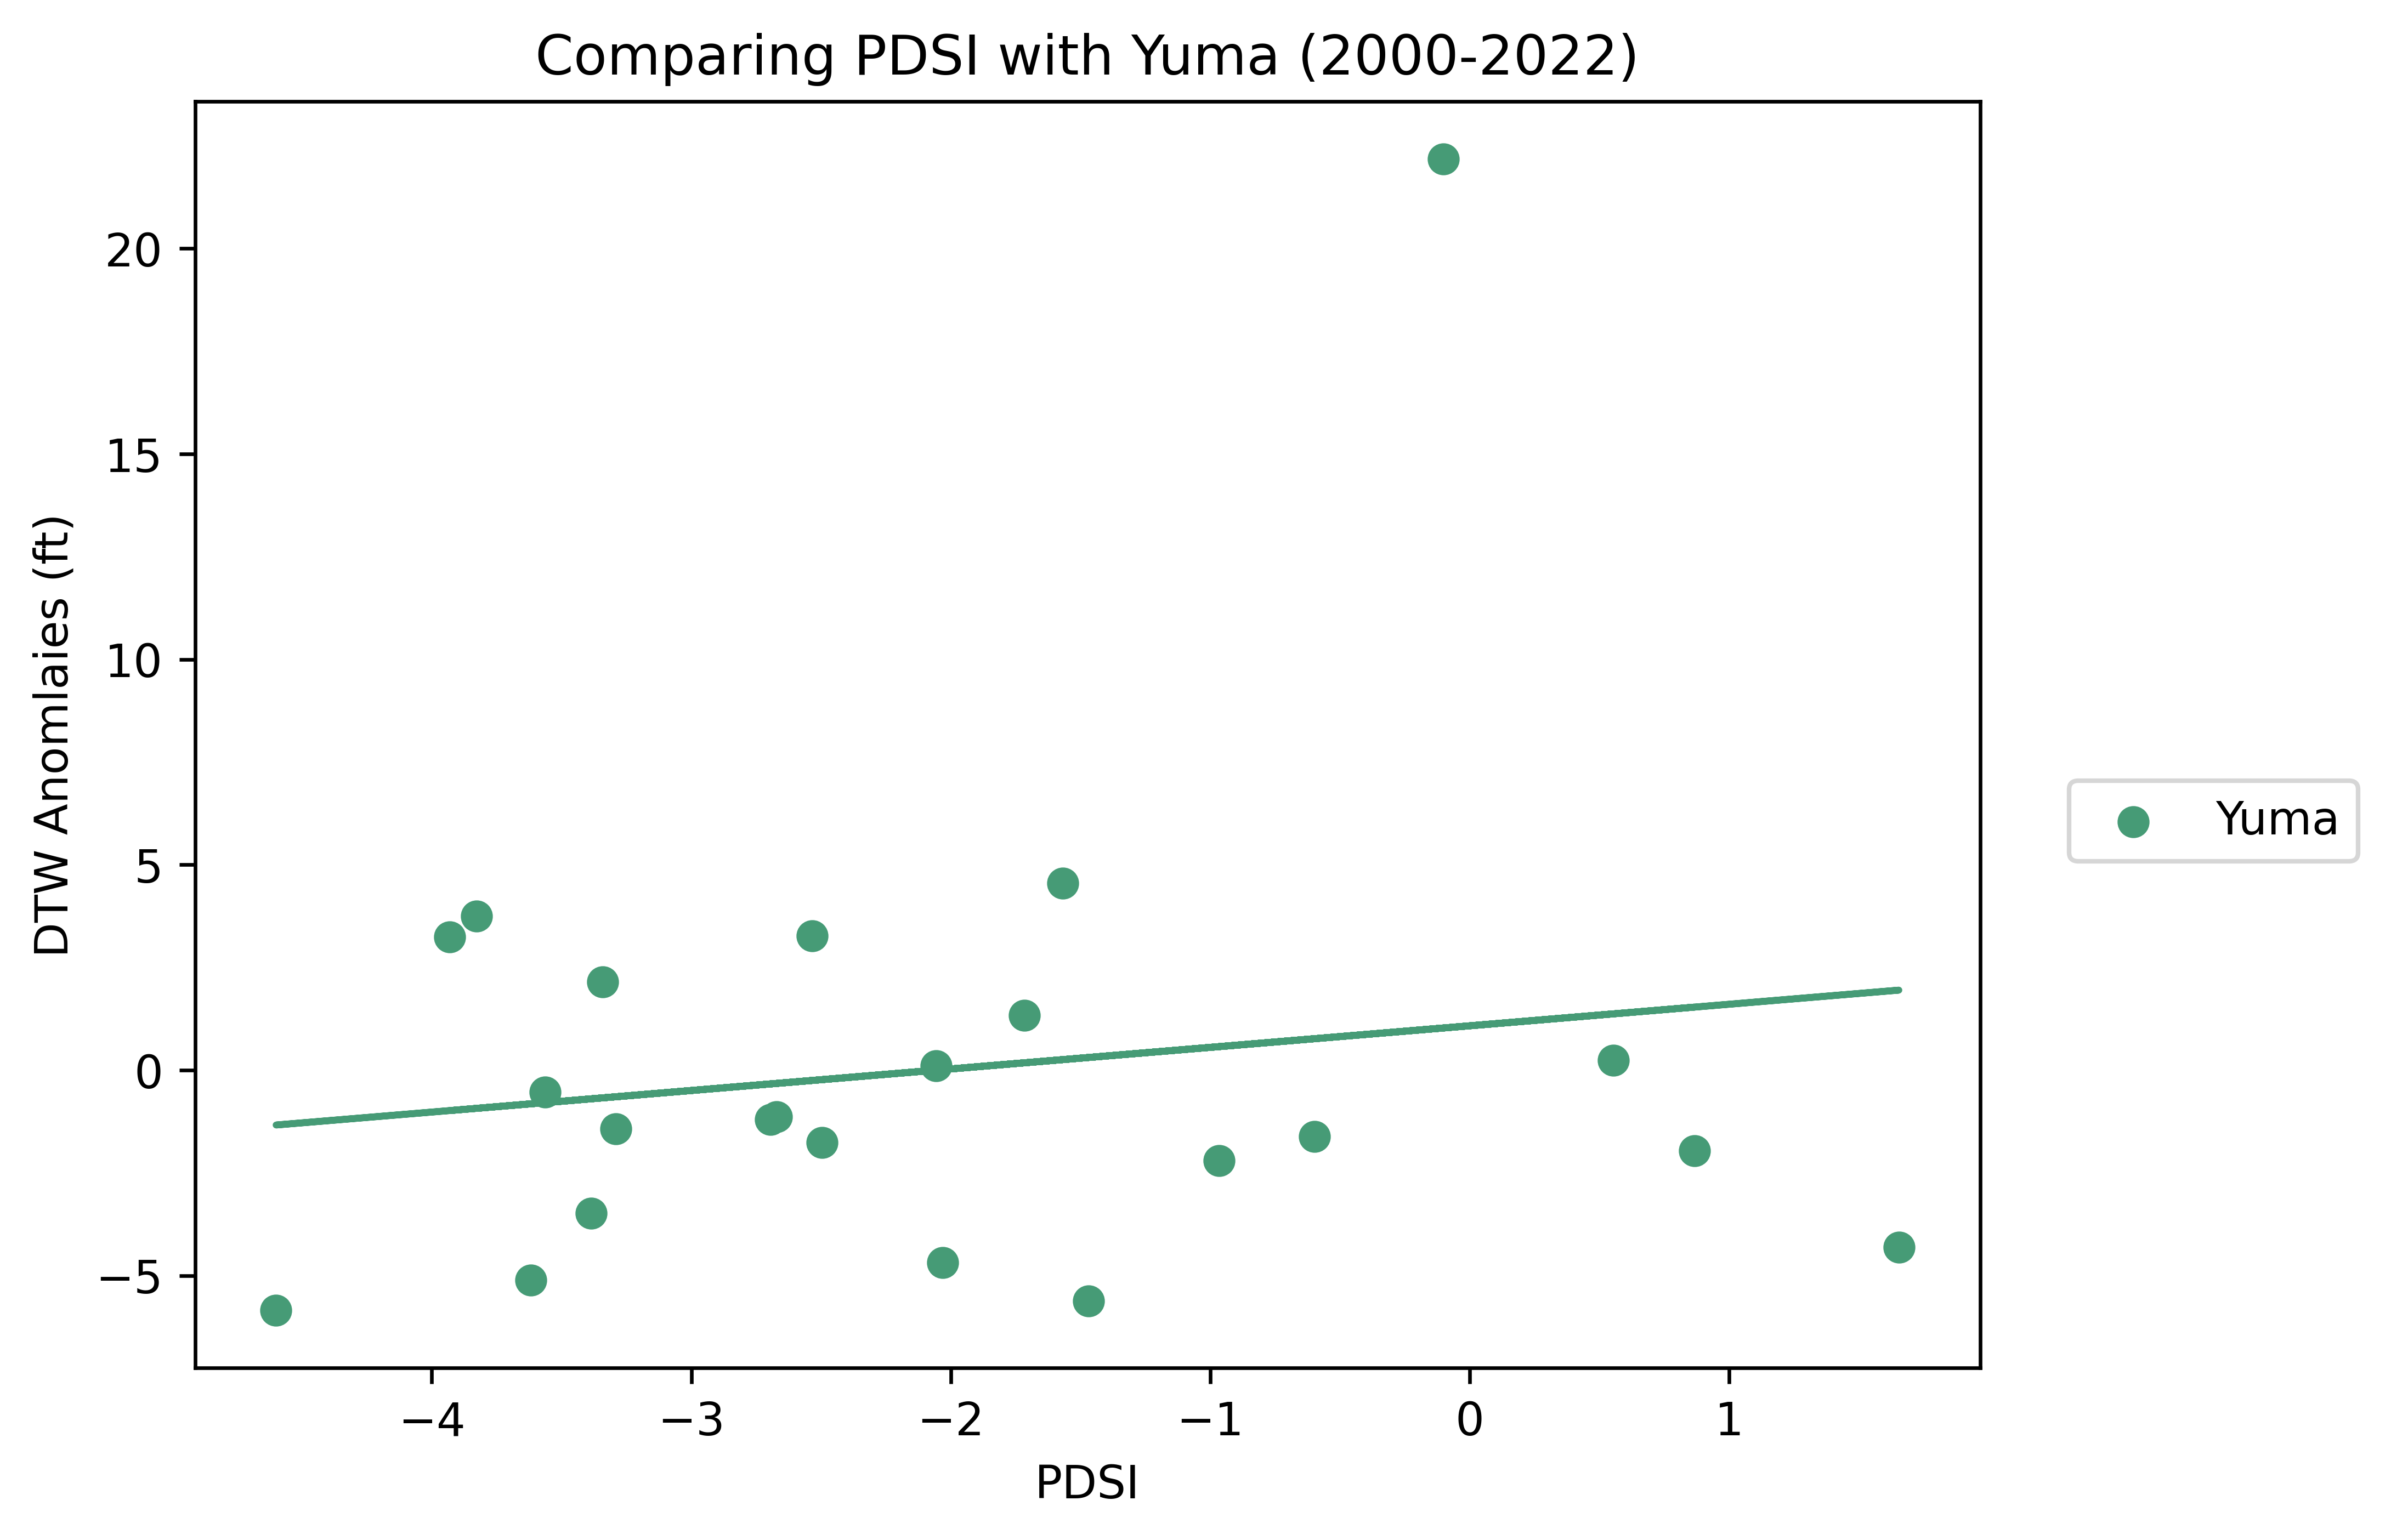

In [22]:
test_name = StudyArea+" ("+str(Min_year_of_Study)+"-"+str(Max_year_of_Study)+")"
ds = dtw_anomalys
drought = drought_indices
lag = 0
indice = 'PDSI'

vert_axis = "DTW Anomlaies (ft)"

color=[swdom]

result = cf.correlation_test(ds, drought, indice, lag,test_name,color,betterlabels,vert_axis)
print(result)

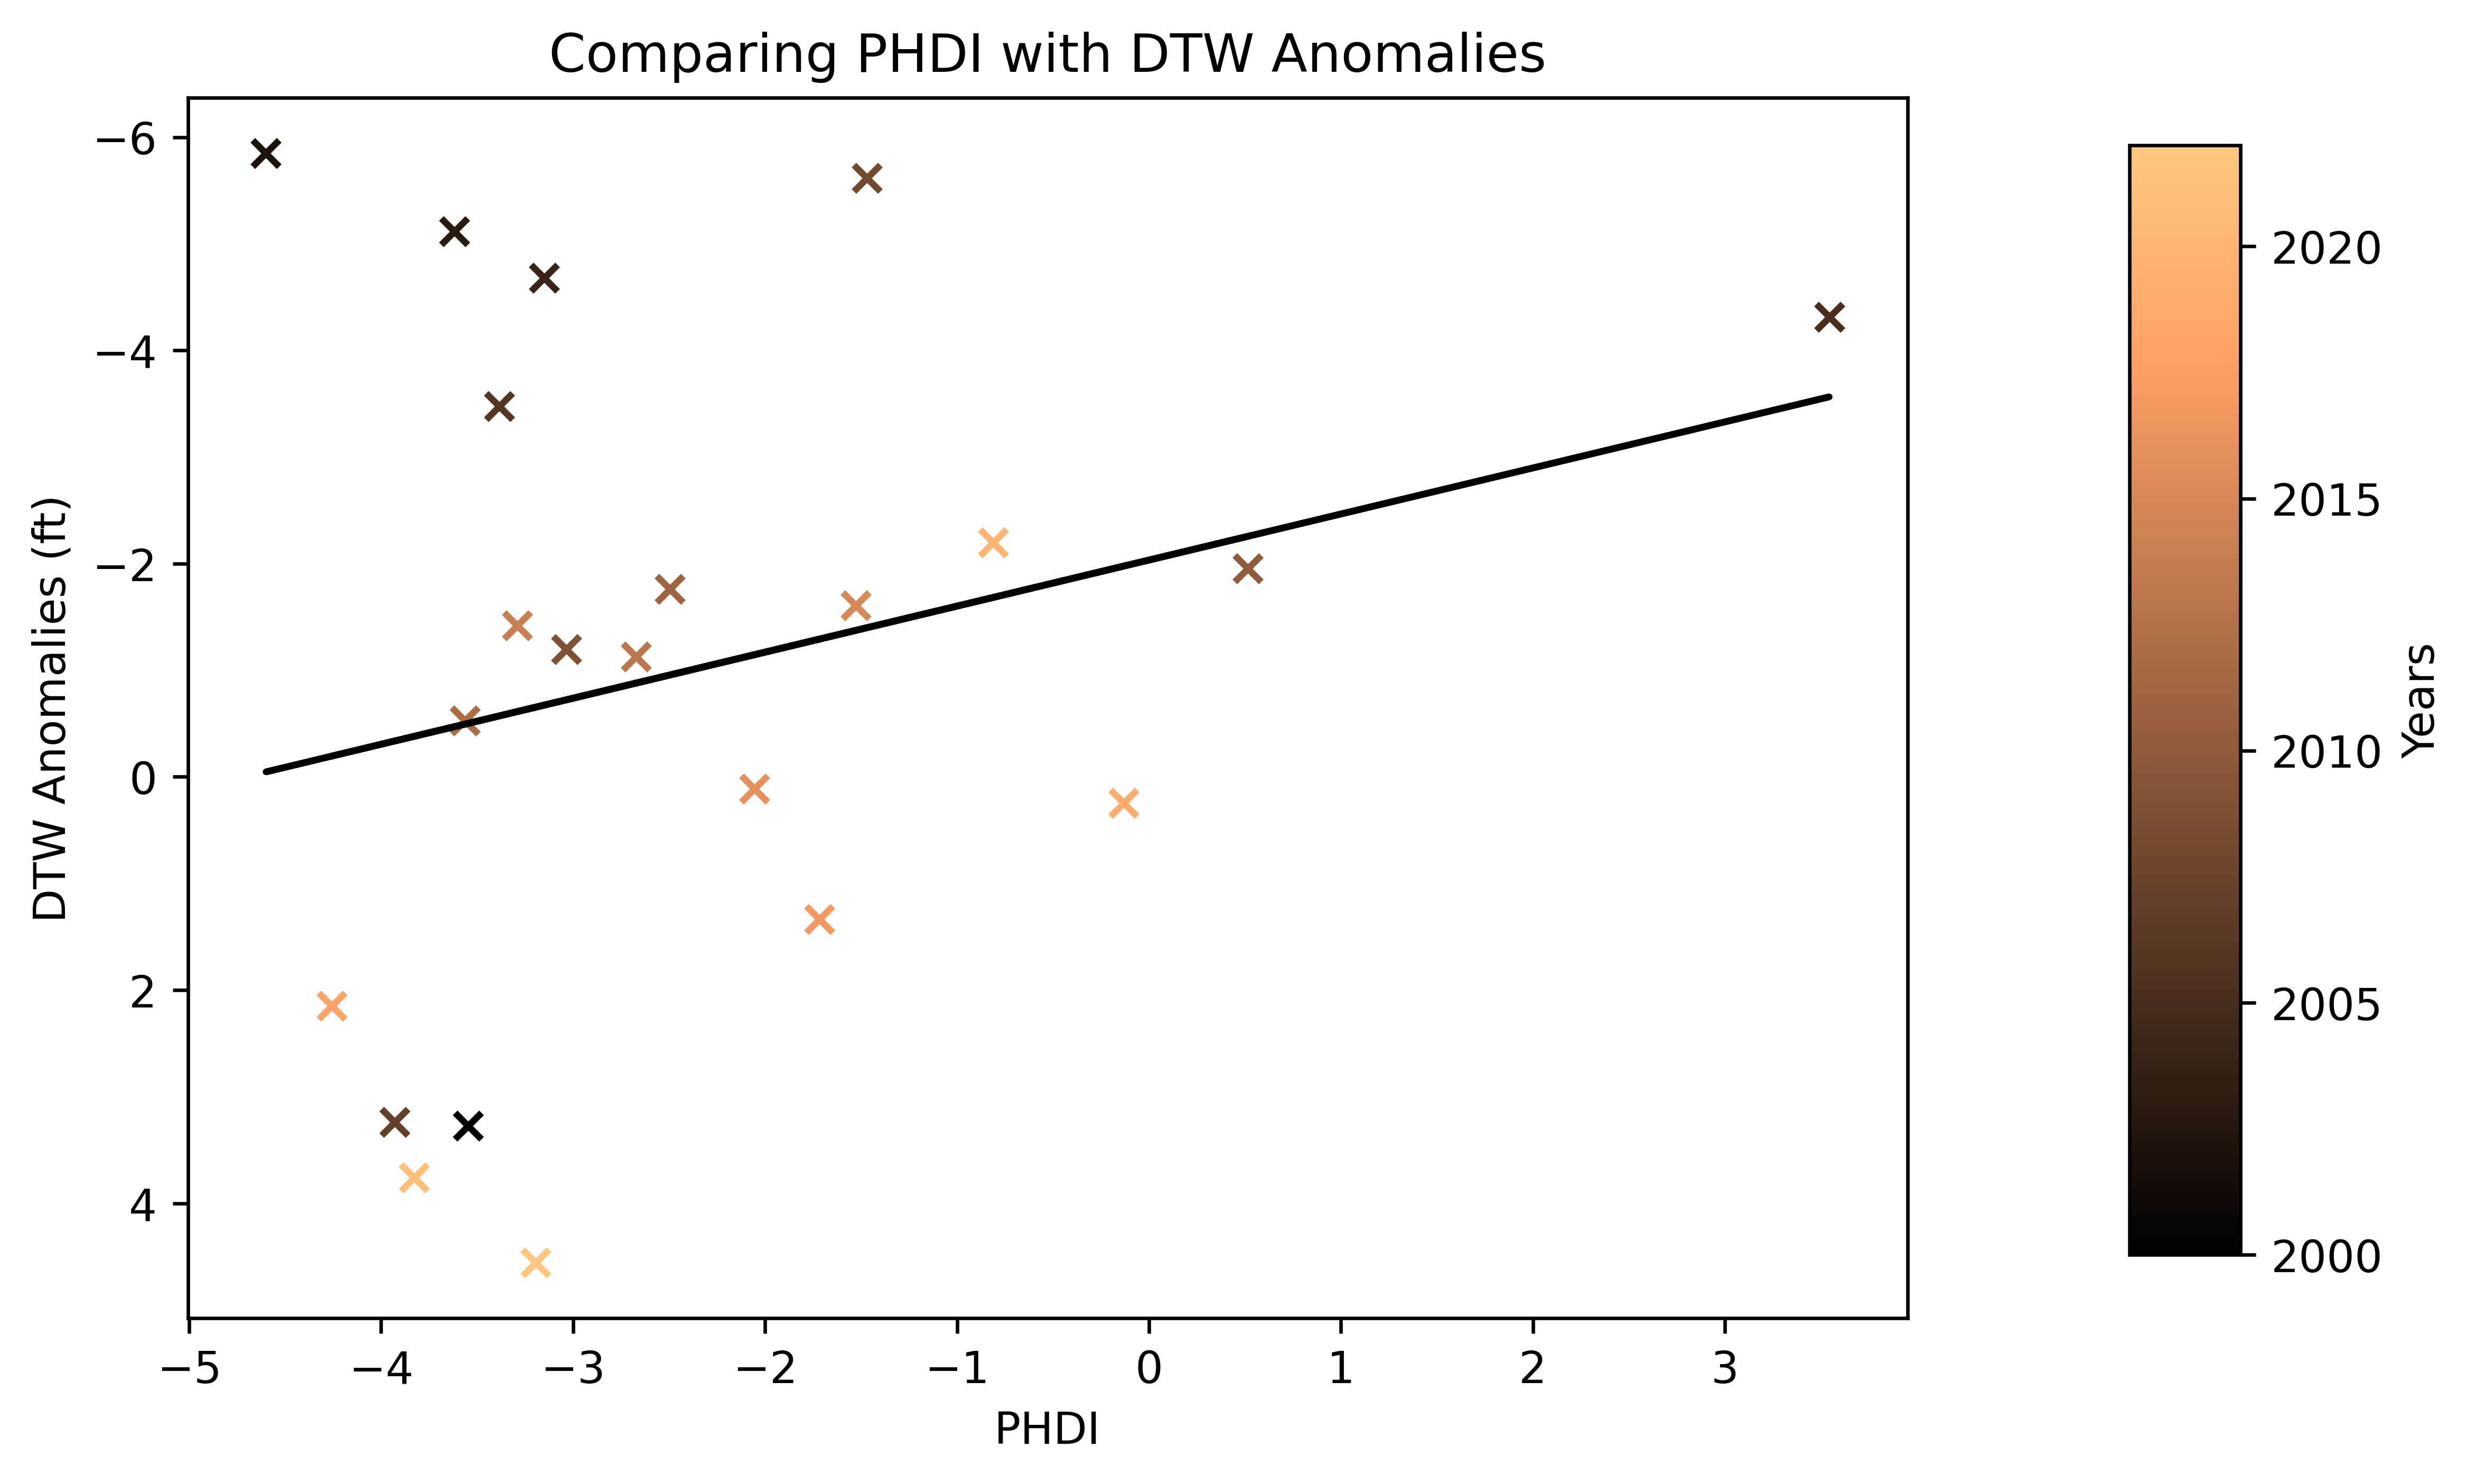

In [75]:
indice = 'PHDI'
# Scatterplot of correlation values
ds = dtw_anomalys.copy()

# # Define a threshold for extreme values
threshold = 20  # Example threshold value, adjust as needed

# # Replace extreme values with NaN
ds = ds.applymap(lambda x: np.nan if x > threshold else x)

# Ensure index names are consistent
ds.index.name = 'years'
ds.index = ds.index.astype(int)

# Generate a color map based on the years
years = ds.index
norm = mcolors.Normalize(vmin=years.min(), vmax=years.max())
colors = cm.copper(np.linspace(0, 1, len(years)))
color_map = {year: color for year, color in zip(years, colors)}

name = 'Comparing ' + indice + ' with DTW Anomalies'
columns = ds.columns
column_list = ds.columns.tolist()
betterlabels = [StudyArea]

fig, ax = plt.subplots(figsize=(7, 5))

x = drought_indices[indice]

# AZ Wells
for i, j in zip(column_list, betterlabels):
    y = ds[i]
    for year in ds.index:
        ax.scatter(x.loc[year], y.loc[year], label=f"{j} {year}", color=color_map[year], marker='x'
                   ,alpha=1
                   )
    # z = np.polyfit(x2, y2, 1)
    # p = np.poly1d(z)
    # plt.plot(x2, p(x2), '-', color=az_wells_color, alpha=1)  # Changed to black for clarity
    # Drop NaN values before fitting
    valid_mask = ~y.isna()
    valid_x2 = x[valid_mask]
    valid_y2 = y[valid_mask]

    if len(valid_x2) > 0 and len(valid_y2) > 0:  # Ensure there are enough points to fit
        z = np.polyfit(valid_x2, valid_y2, 1)
        p = np.poly1d(z)
        plt.plot(valid_x2, p(valid_x2), '-', color='black', alpha=1)  # Changed to black for clarity

# Reverse the order of the secondary y-axis
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_xlabel(indice)
# ax2.set_ylabel('LWE Anomalies (cm)')
ax.set_ylabel('DTW Anomalies (ft)')
ax.set_title(name, loc='center')
fig.set_dpi(600)

# Adding a color bar to represent the years, positioned manually
sm = plt.cm.ScalarMappable(cmap=cm.copper, norm=norm)
sm.set_array([])  # Only needed for older versions of matplotlib

# Specify the position of the color bar using a rectangle (x, y, width, height)
cbar_position = [1.0, 0.15, 0.05, 0.7]  # Adjust these values as needed
cbar_ax = fig.add_axes(cbar_position)
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Years')

# Set color bar ticks to show every 5 years
tick_locations = np.arange(years.min(), years.max() + 1, 5)
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_locations)

plt.show()

# plt.savefig(outputpath+name, bbox_inches='tight')


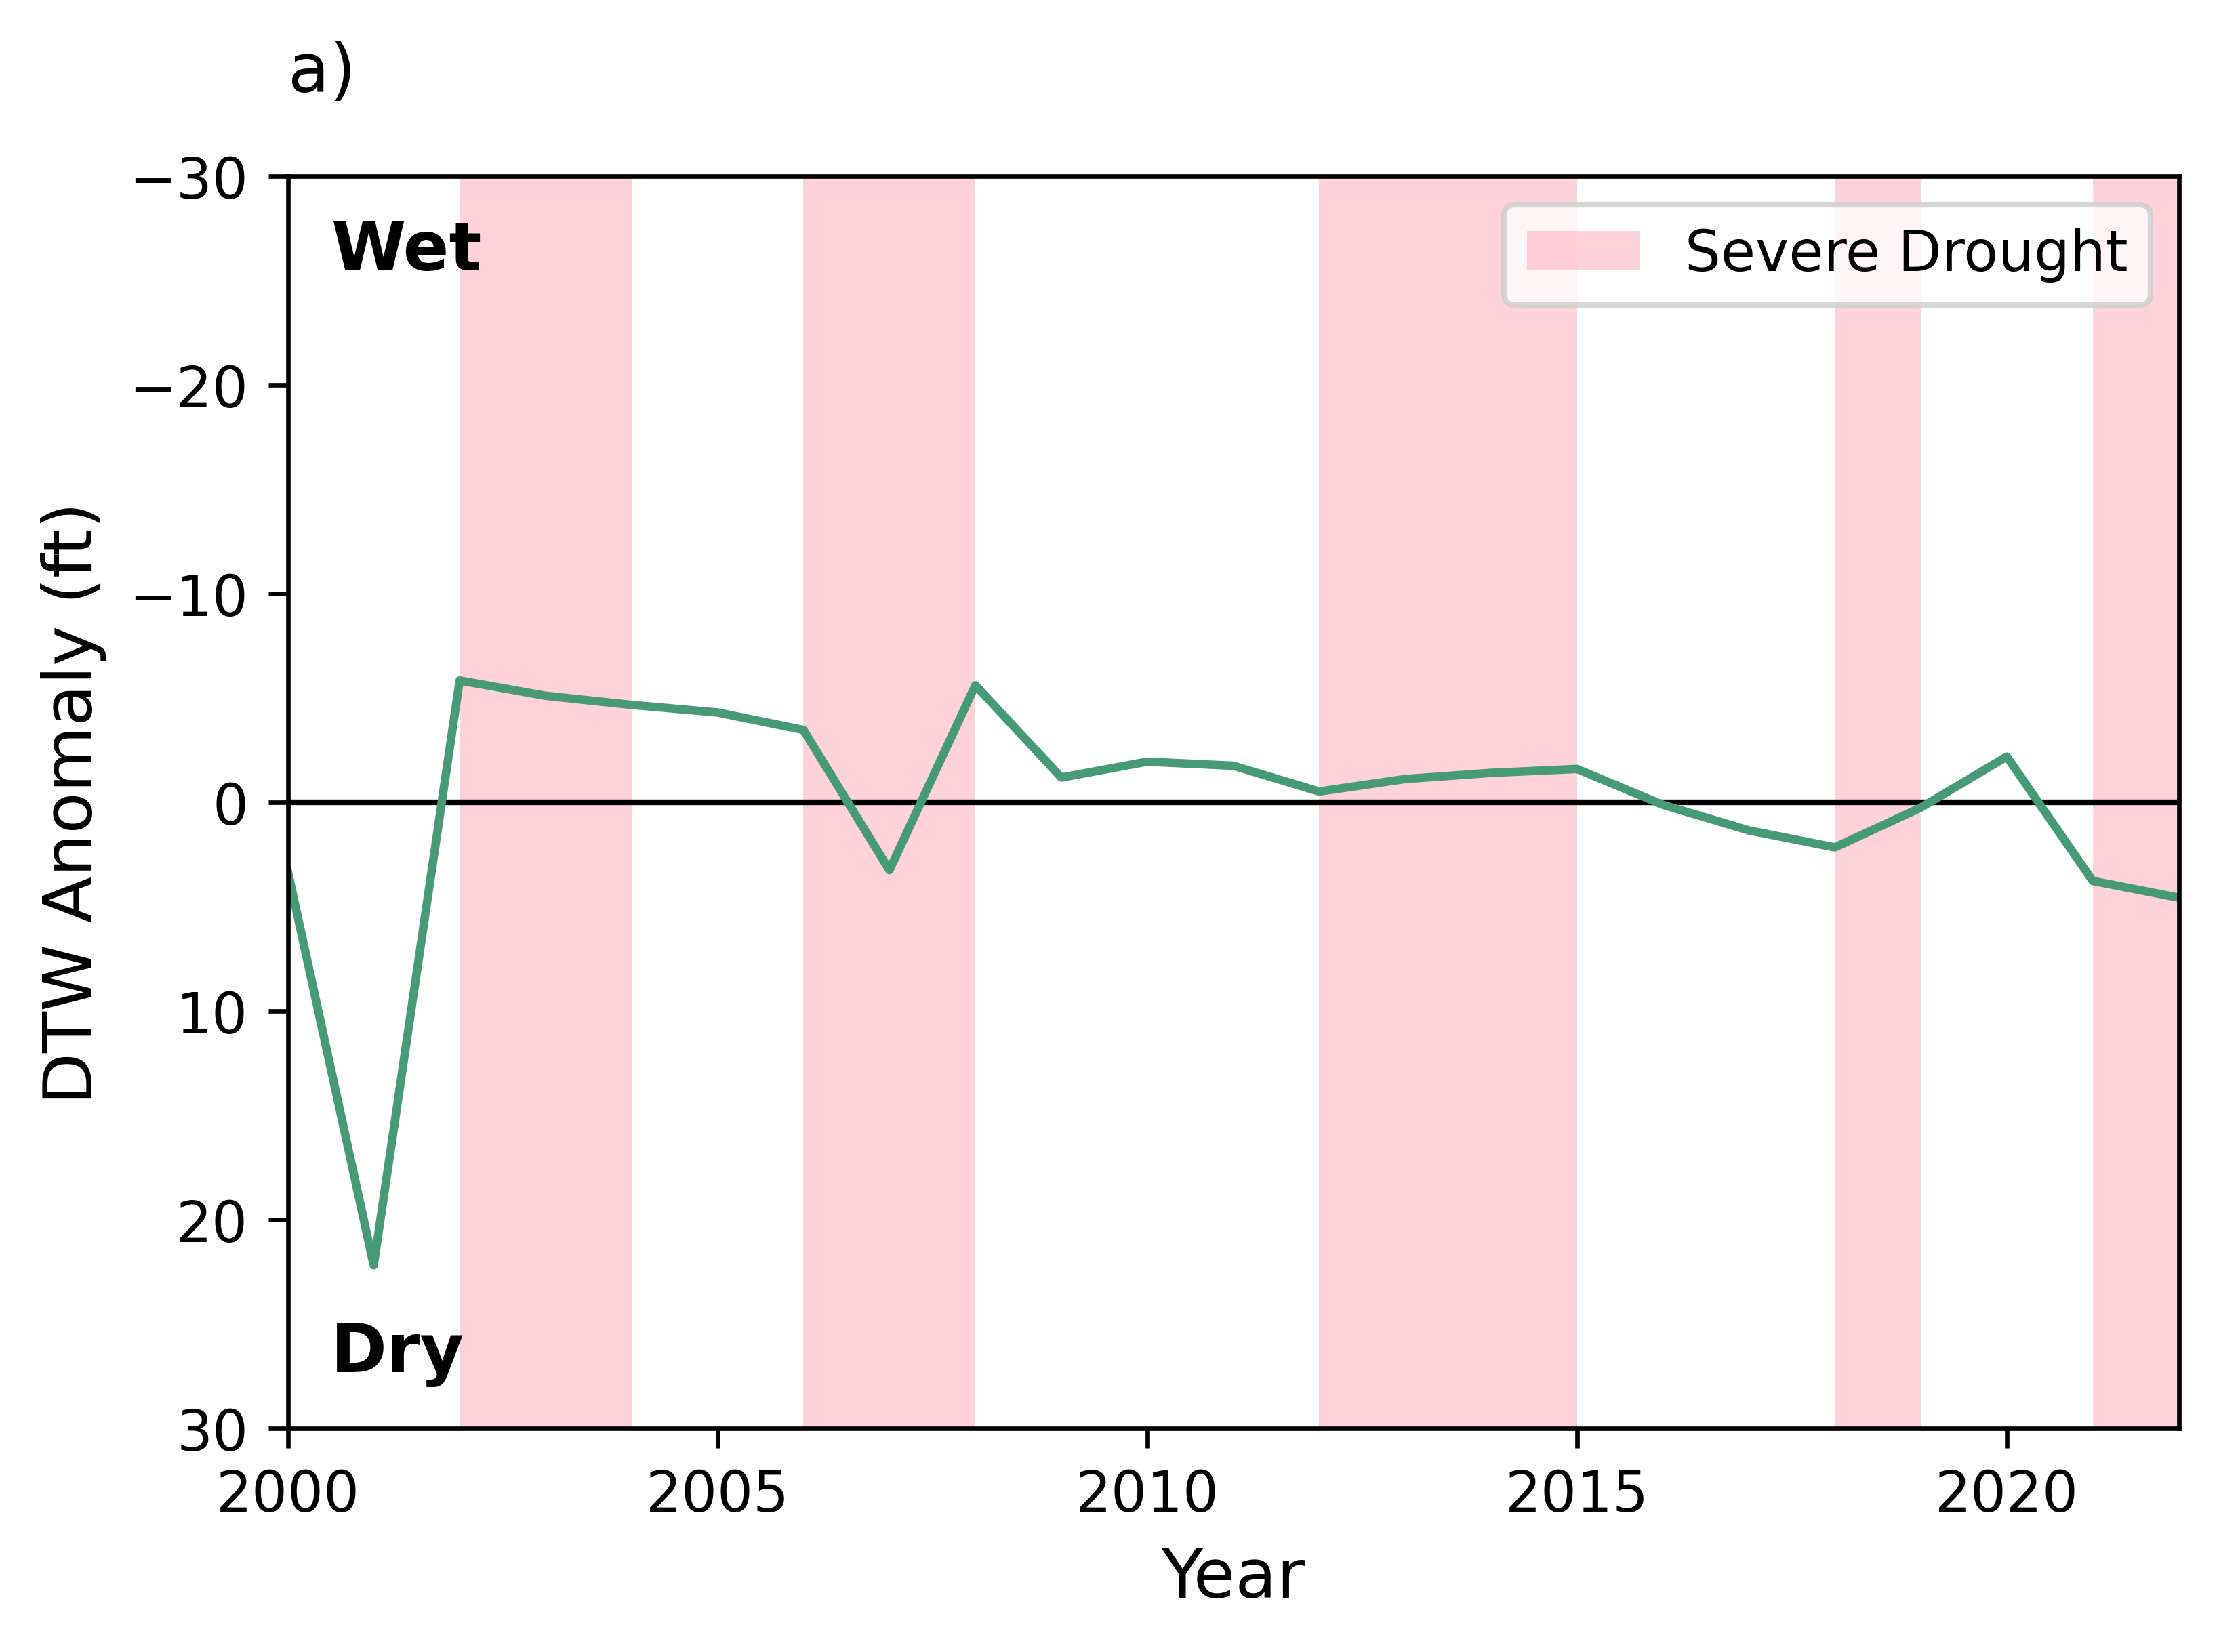

In [64]:
ds = dtw_anomalys
min_yr = 2000
mx_yr = 2022

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

ylim = 30
fsize = 12
# Set x ticks to every 5 years
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

# Severe Drought Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

ax.plot(ds[column_list[0]], color=water_designation, lw=1.5)
plt.axhspan(0,0,color='black',lw=1)

# Adding text inside the plot
ax.text(min_yr+0.5, 2-ylim, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax.text(min_yr+0.5, ylim-2, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(ylim,-ylim)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=0)
fig.set_dpi(600.0)
ax.set_title('a)',loc='left',pad=15, fontsize = fsize)
ax.legend(loc='upper right')

# plt.savefig(figurepath+'Timeseries of DTW Anomalies for '+StudyArea, bbox_inches = 'tight')

Calculating Max Drawdown (maximum anomaly in the drought period)

In [65]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_max_anomalies = ds.groupby(['Status']).max()
dtw_max_anomalies
# ds

,YUMA
Status,
Drought 3,-5.11
Drought 4,3.24
Drought 5,-0.53
Drought 6,2.15
Drought 7,3.76
Normal-Wet,22.18


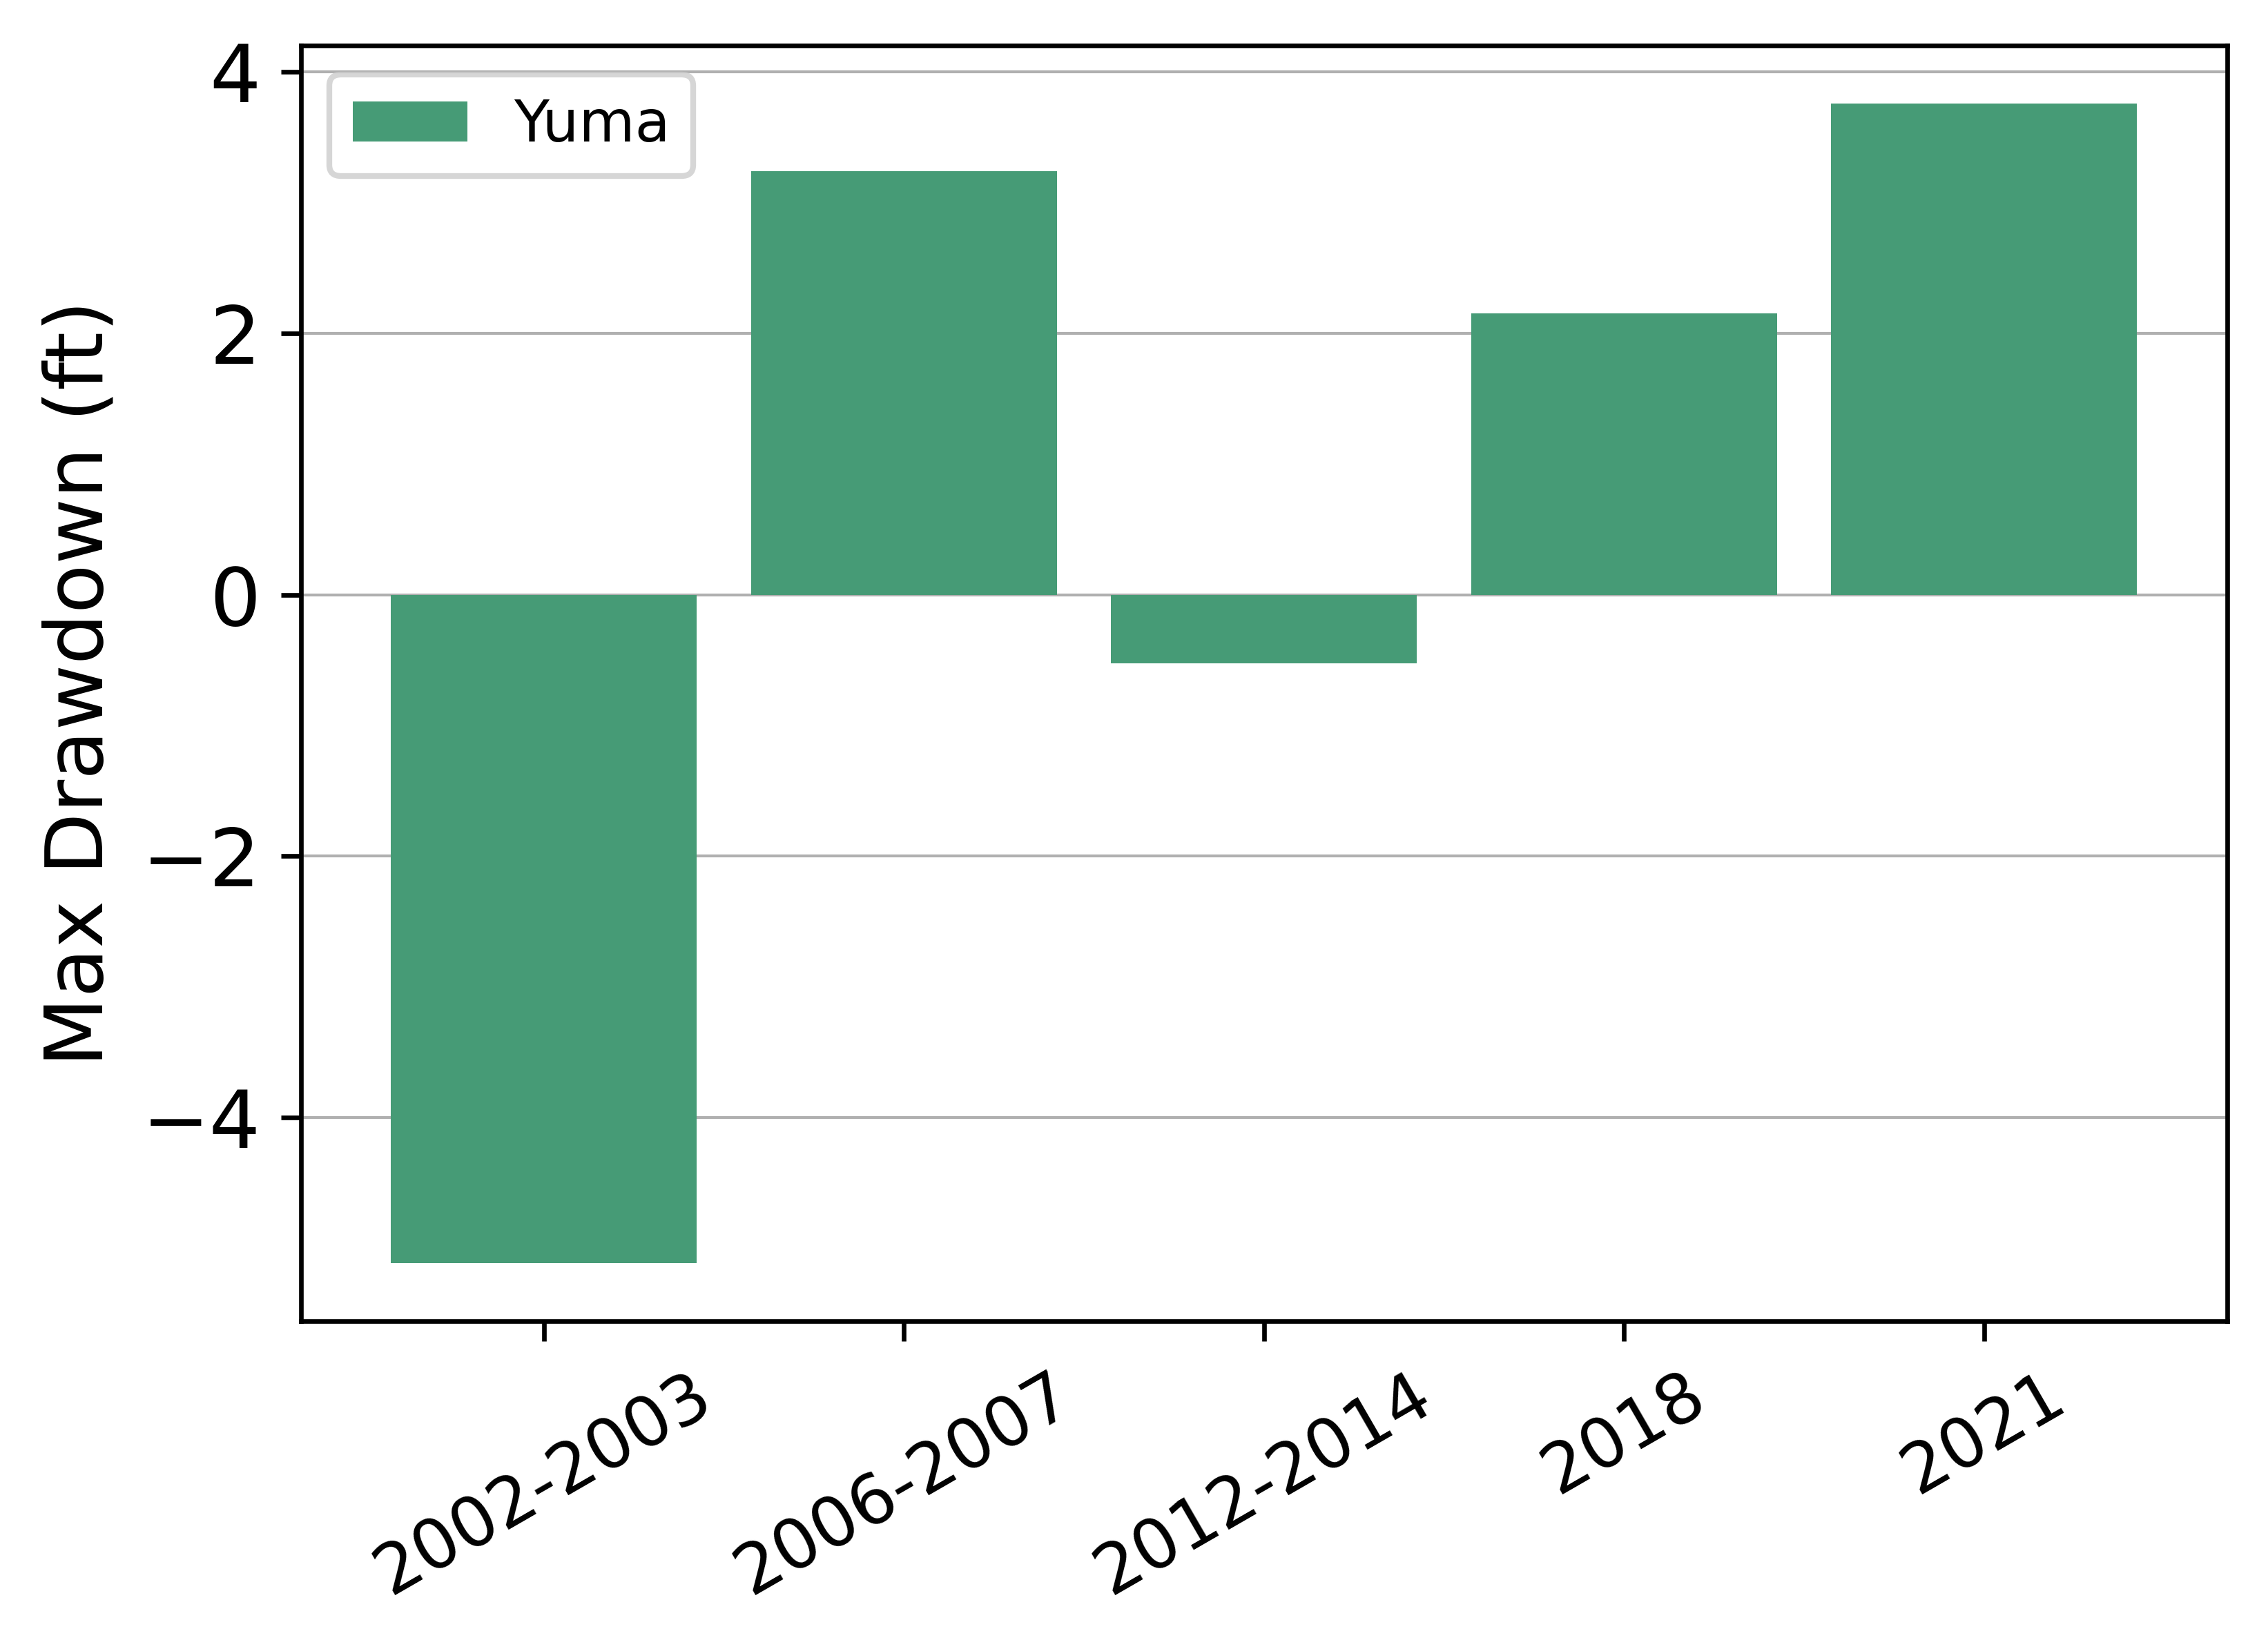

In [66]:
#%% Grouped Bar chart for drawdown (ft)
# name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
name = 'Max Drawdown by Drought Period for '+StudyArea

yearlabels = [
                # "1989-1990"
        #       ,'1996',
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]
# betterlabels = ['CAP','Regulated \n Groundwater','Surface \n Water','Unregulated \n Groundwater','Mixed \n GW/SW'] 
# betterlabels = [StudyArea]

dtw_max_anomalies.index = yearlabels
dtw_max_anomalies = dtw_max_anomalies.transpose()

dtw_max_anomalies.index = betterlabels
del dtw_max_anomalies['Normal/Wet Years']
dtw_max_anomalies = dtw_max_anomalies.transpose()

group_colors = [water_designation]

horlabel = 'Max Drawdown (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_max_anomalies.plot(figsize = (6,4),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
# plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=30, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
# plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_anomalies_groupedchart', bbox_inches = 'tight')

Run this to determine how many new wells were drilled per year in the area

In [67]:
# New wells

static_geo2['INSTALLED'] = pd.to_datetime(static_geo2['INSTALLED'])
# static_geo2['INSTALLED'].describe()

static_geo2['In_year'] = static_geo2['INSTALLED'].dt.year
new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=[Naming_col+"_right"], values=["INSTALLED"], dropna=False, aggfunc=len)
# new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=[Naming_col], values=["INSTALLED"], dropna=False, aggfunc=len)
# new_wells = new_wells.reset_index()
new_wells.to_csv(outputpath+'Final_NewWells_'+StudyArea+'.csv')

In [68]:
# To get it formatted correctly

new_wells2 = pd.read_csv(outputpath+'Final_NewWells_'+StudyArea+'.csv',
                        header=2,
                        # names = ['R','Res','U']
                        names = betterlabels
                        # names = [StudyArea]
                        , index_col=0)
new_wells2

,Yuma
1930.00,1
1945.00,1
1946.00,1
1947.00,1
1951.00,2
...,...
2019.00,20
2020.00,43
2021.00,71
2022.00,40


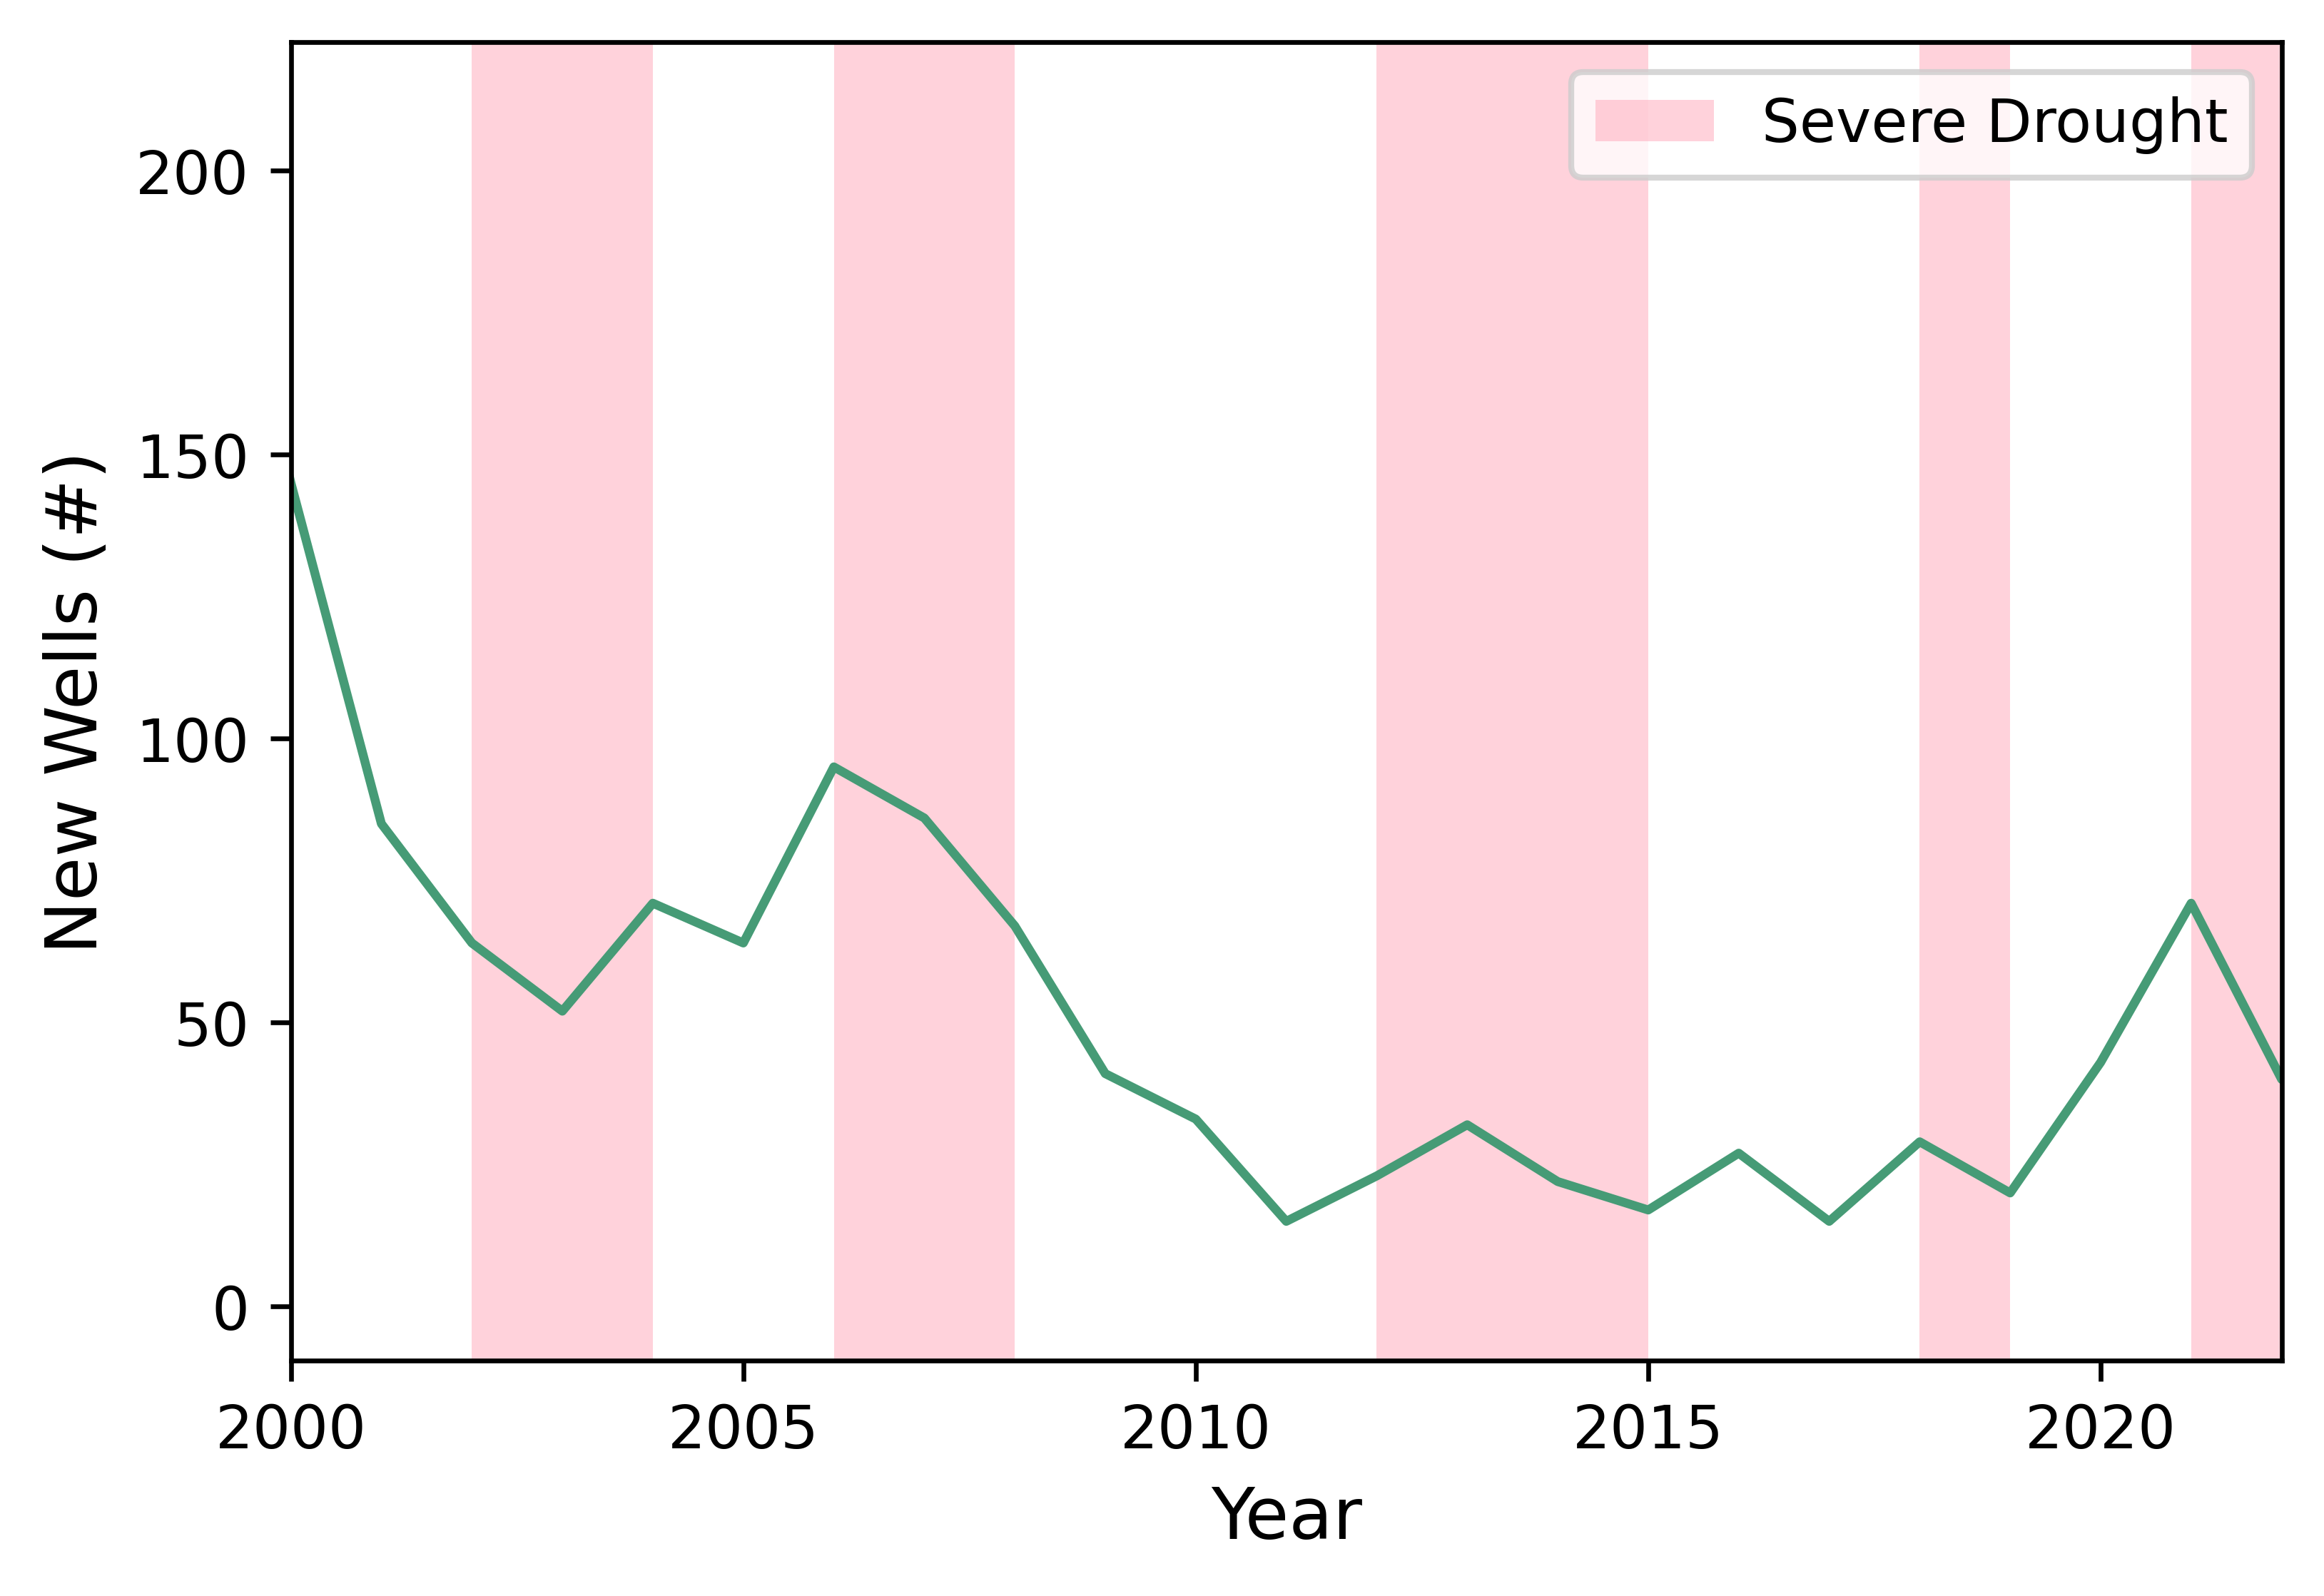

In [69]:
ds = new_wells2
min_yr = 2000
mx_yr = 2022
# betterlabels = ['Regulated','Unregulated']

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = -12
max_y = 15
fsize = 12
num_years = mx_yr - min_yr + 1
ax.set_xticks(np.linspace(min_yr, mx_yr, num_years))
ax.set_xticklabels(map(int, ax.get_xticks()))

# Severe Drought Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

ax.plot(ds[column_list[0]], color=water_designation, lw=1.5) 
# ax.plot(ds[column_list[0]], color=blind[1],label=betterlabels[0]) 
# ax.plot(ds[column_list[1]], color=blind[2],label=betterlabels[1]) 
# ax.plot(ds[column_list[2]], color=blind[6],label=betterlabels[2])  

ax.set_xlim(min_yr,mx_yr)
# ax.set_ylim(min_y,max_y)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.tick_params(axis='x', rotation=0)
ax.set_ylabel('New Wells (#)',fontsize=fsize)
# ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

# Set x ticks to every 5 years
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

plt.savefig(figurepath+'Timeseries of New Wells for '+StudyArea, bbox_inches = 'tight')